In [60]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as N
import pandas as pd
from scipy.linalg import svd
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
import json
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

seed=12345



#File with the multipole data to be fitted
inputfile_multipole_training='/global/homes/s/sadiram/KP5/GSM_EFT/gsm/dataNN/z0.8ns/monopole_z0.8points80000.csv'
inputfile_multipole_validation='/global/homes/s/sadiram/KP5/GSM_EFT/gsm/dataNN/z0.8ns/monopole_valset_z0.8points5000.csv'
inputfile_multipole_test='/global/homes/s/sadiram/KP5/GSM_EFT/gsm/dataNN/z0.8ns/monopole_test_z0.8points5000.csv'

#File with the parameters to be explored
inputfile_param_training=  '/global/homes/s/sadiram/KP5/GSM_EFT/gsm/dataNN/z0.8ns/korobov_80000.csv'
inputfile_param_validation='/global/homes/s/sadiram/KP5/GSM_EFT/gsm/dataNN/z0.8ns/korobov_valset_5000.csv'
inputfile_param_test=      '/global/homes/s/sadiram/KP5/GSM_EFT/gsm/dataNN/z0.8ns/korobov_test_5000.csv'
#File were we store the output of the NN
outpufile="/global/cfs/projectdirs/desi/users/sadiram/KP5_proyect/Abacus_LRG/FullModeling/Emulator/z0.8ns/Weigth_mono_sinh_new_z0.8.json"
name_plot="/global/cfs/projectdirs/desi/users/sadiram/KP5_proyect/Abacus_LRG/FullModeling/Emulator/z0.8ns/Percent_error_mono_sinh_new_z0.8.pdf"

# We begin by reeding the cosmological parameters

In [61]:
param_train=pd.read_csv(inputfile_param_training,sep=',', header=0).values
N_param=len(param_train[0])#number of parameters

param_test=pd.read_csv(inputfile_param_test,sep=',', header=0).values
param_val=pd.read_csv(inputfile_param_validation,sep=',', header=0).values


In [62]:
multipole_test=pd.read_csv(inputfile_multipole_test,sep=',', header=0).values
multipole_val=pd.read_csv(inputfile_multipole_validation,sep=',', header=0).values
multipole_train=pd.read_csv(inputfile_multipole_training,sep=',', header=0).values



indices_nan = N.where(N.isnan(multipole_val))
print(indices_nan)
indices_nan = N.where(N.isnan(multipole_test))
print(indices_nan)
indices_nan = N.where(N.isnan(multipole_train))
print(indices_nan)


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([30153, 34422, 37124, 38271, 48053, 58138, 76164]), array([11,  7, 14,  0,  6,  0,  8]))


# We read our multipoles and plot the first 5 to check they look ok

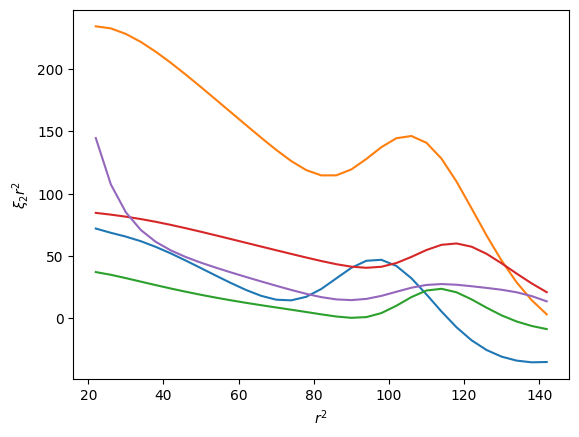

In [46]:
DF_cf=pd.read_csv(inputfile_multipole_training,sep=',', header=0)
rbin_1MPC=DF_cf.columns.values.astype('float')
multipole_train=DF_cf.values

for index in range(5):
    
      index=4143+index
      plt.plot(rbin_1MPC,multipole_train[index]*rbin_1MPC**2)
      plt.ylabel(r'$\xi_2r^2$')
      plt.xlabel(r'$r^2$')

# Divide data into train and test set. Note that this will be delated when Sadi makes different files for each set

In [64]:
multipole_test=pd.read_csv(inputfile_multipole_test,sep=',', header=0).values
multipole_val=pd.read_csv(inputfile_multipole_validation,sep=',', header=0).values

In [65]:
multipole_train[N.isnan(multipole_train)] = 0
multipole_test[N.isnan(multipole_test)] = 0
multipole_val[N.isnan(multipole_val)] = 0

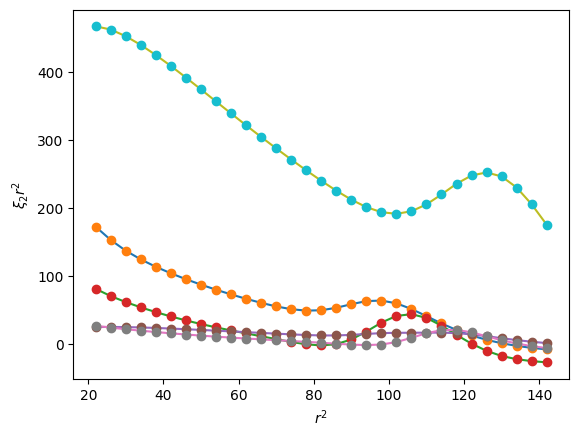

In [66]:
smin=22; smax=142 ; Ns=31
rbin=N.linspace(smin, smax, Ns)

def rebin(multi):
   return N.interp(rbin, rbin_1MPC, multi)


for index in range(5):
      plt.plot(rbin_1MPC,multipole_train[index]*rbin_1MPC**2)
      plt.plot(rbin,rebin(multipole_train[index])*rbin**2,'o')
      plt.ylabel(r'$\xi_2r^2$')
      plt.xlabel(r'$r^2$')

In [67]:
N_bins=len(multipole_train[0])

In [68]:
multipole_test.shape

(5000, 31)

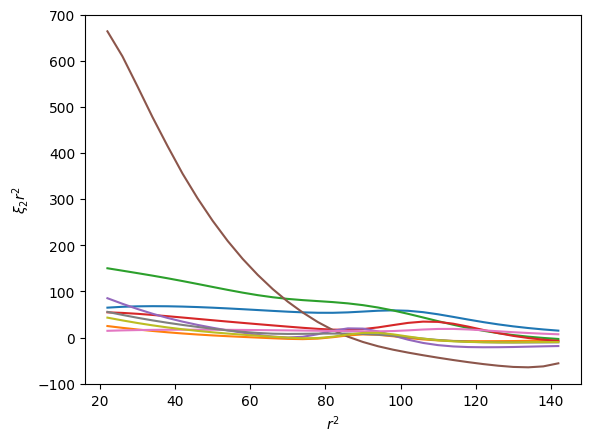

In [69]:
multipole_train=N.array([rebin(multipole_train[ii]) for ii in range(len(multipole_train))])
multipole_test=N.array([rebin(multipole_test[ii]) for ii in range(len(multipole_test))])
multipole_val=N.array([rebin(multipole_val[ii]) for ii in range(len(multipole_val))])



for index in range(3):
      index=3434+index
      plt.plot(rbin,multipole_train[index]*rbin**2)
      plt.plot(rbin,multipole_test[index]*rbin**2)
      plt.plot(rbin,multipole_val[index]*rbin**2)
      plt.ylabel(r'$\xi_2r^2$')
      plt.xlabel(r'$r^2$')

# We normalize the data using the arcsinh normalisation and see how the multipoles look after normalisation

In [70]:
param_test.shape

(5000, 10)

In [71]:
param_mean=N.mean(param_train,axis=0)
param_std=N.std(param_train,axis=0)

param_test_norm=(param_test-param_mean)/param_std
param_train_norm=(param_train-param_mean)/param_std
param_val_norm=(param_val-param_mean)/param_std

multi_std=N.std(multipole_train, axis=0)

multipole_train_sinh=N.arcsinh(multipole_train/multi_std)
multipole_test_sinh = N.arcsinh(multipole_test/multi_std)
multipole_val_sinh = N.arcsinh(multipole_val/multi_std)

In [72]:
indices_nan = N.where(N.isnan(multipole_train))

In [73]:
indices_nan = N.where(N.isnan(multipole_test_sinh))

In [74]:
indices_nan = N.where(N.isnan(multipole_val_sinh))

In [75]:
indices_nan

(array([], dtype=int64), array([], dtype=int64))

In [76]:
multi_std

array([0.76341496, 0.3493413 , 0.21638656, 0.14550919, 0.10239256,
       0.07466589, 0.05628623, 0.04357497, 0.03454958, 0.02798457,
       0.02311919, 0.01944976, 0.01664473, 0.01447432, 0.01279086,
       0.01148707, 0.01048103, 0.00970665, 0.00910902, 0.00864198,
       0.0082747 , 0.00798106, 0.00773834, 0.00753017, 0.007342  ,
       0.00716223, 0.00698249, 0.00679753, 0.00660323, 0.00640365,
       0.00620364])

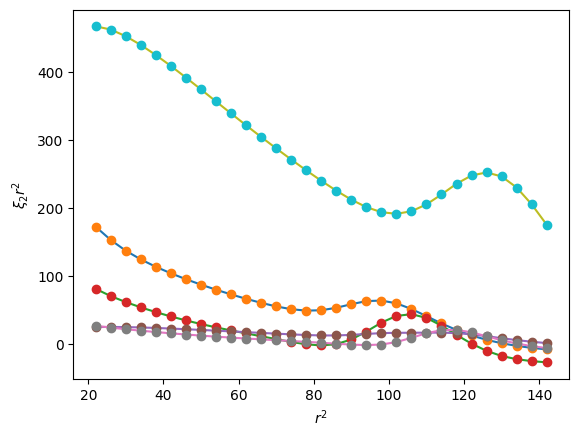

In [77]:
smin=22; smax=142 ; Ns=31
rbin=N.linspace(smin, smax, Ns)

def rebin(multi):
   return N.interp(rbin, rbin_1MPC, multi)


for index in range(5):
      plt.plot(rbin_1MPC,multipole_train[index]*rbin_1MPC**2)
      plt.plot(rbin,rebin(multipole_train[index])*rbin**2,'o')
      plt.ylabel(r'$\xi_2r^2$')
      plt.xlabel(r'$r^2$')

In [78]:
param_test_norm.shape

(5000, 10)

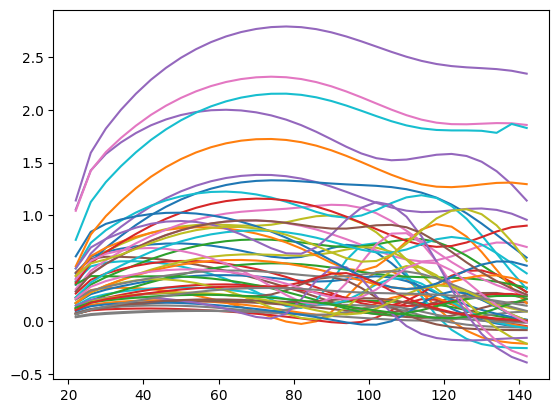

In [79]:
for index in range(50):
      plt.plot(rbin,multipole_train_sinh[index])

# Normalize by the mean and the standard deviation

In [80]:
input_std=N.std(multipole_train_sinh,axis=0)
input_mean=N.mean(multipole_train_sinh,axis=0)

multipole_train_norm=(multipole_train_sinh-input_mean)/input_std
multipole_val_norm=(multipole_val_sinh-input_mean)/input_std



# This class defines our NN emulator and defines our custom activation function


In [81]:
class Emulator(tf.keras.Model):

    def __init__(self, n_params,n_bins,
                 n_hidden):
        super(Emulator, self).__init__()

        trainable = True

        self.n_parameters = n_params
        self.n_hidden = n_hidden
        self.n_bins=n_bins
        
        #Lets tf know the number of input and output values and the number of hidden layers
        self.architecture = [self.n_parameters] + \
            self.n_hidden + [self.n_bins]
        self.n_layers = len(self.architecture) - 1
        
        self.W = []
        self.b = []
        self.alphas = []
        self.betas = []

        
        '''
        This initiates the architecture of the NN adding all parameters  W, b, alpha and beta 
        to their respective lists and giving a random initial point to each of them
        it also lets tf know that they are trainable parameters
        '''

        for i in range(self.n_layers):
            self.W.append(tf.Variable(tf.random.normal([self.architecture[i], self.architecture[i+1]], 0., N.sqrt(
                2./self.n_parameters)), name="W_" + str(i), trainable=trainable))
            self.b.append(tf.Variable(
                tf.zeros([self.architecture[i+1]]), name="b_" + str(i), trainable=trainable))
        for i in range(self.n_layers-1):
            self.alphas.append(tf.Variable(tf.random.normal(
                [self.architecture[i+1]]), name="alphas_" + str(i), trainable=trainable))
            self.betas.append(tf.Variable(tf.random.normal(
                [self.architecture[i+1]]), name="betas_" + str(i), trainable=trainable))
    
    
    ''''
    Custom activation Function, takes the output of a layer and applies the function
    ussing the alpha and beta new free parameters of DeROSE. 
    Note that we use the tensor functions for addition and multiplication as they are very optimised for 
    this sort of problems
    '''
    def activation(self, x, alpha, beta):
        return tf.multiply(tf.add(beta, tf.multiply(tf.sigmoid(tf.multiply(alpha, x)), tf.subtract(1.0, beta))), x)
    
    
    '''
    This is the function that activates at every step and computes the outputs of one run of the neural netwrok 
    at the current value of the free parameters
    '''
    @tf.function
    def call(self, parameters):

        outputs = []
        #input layer
        x = parameters

        for i in range(self.n_layers - 1):

            # linear network operation
            x = tf.add(tf.matmul(x, self.W[i]), self.b[i])

            # non-linear activation function
            x = self.activation(x, self.alphas[i], self.betas[i])

        # linear output layer
        x = tf.add(tf.matmul(x, self.W[-1]), self.b[-1])
        return x

# We define our Neural Network architecture

In [82]:
model = Emulator(n_params=N_param,n_bins=N_bins , n_hidden=[128, 128, 128,128])

2024-02-12 12:51:15.834747: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-12 12:51:15.834794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nid200205): /proc/driver/nvidia/version does not exist
2024-02-12 12:51:15.835559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# We train ussing different lerning rates and batch sizes, This is very similar to the code  from DeRose paper and I want to modify it before we make the code public.

In [83]:
#Note that if we where to make this code public we should change it sligthly.

#All diferent lerning rates that we explore
learning_rate = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
N_learning_rate=len(learning_rate)

#Smaller lerning rates normally benefit from
nbatchs = [320, 640, 1280, 2560, 5120]
#Maximum number of steps to do per lerning rate
n_epochs=20000


'''
We ask the model to set  the Mean square error as its loss function(the function the NN tries to improve. 
We also ask it to save other metrics.
'''

model.compile(loss='mse', metrics=['mse','mae','mape'],optimizer='adam')

#We ask the code to stop training at a given lerning rate if it has not seen any improvemnt on the 
Early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

epochs_values=[]


#we loop over our desiered lerning rates
for ii in range(N_learning_rate):
        lrate=learning_rate[ii]
        batch=nbatchs[ii]
        # set the lerning rate before each training
        model.optimizer.lr = lrate
        
        #we save each layer output information into a list so that we can latter print some statistics
        epochs_values+=[model.fit(param_train_norm, multipole_train_norm,validation_data=(param_val_norm, multipole_val_norm),\
                  epochs=n_epochs, batch_size=batch, callbacks=[Early_stop], verbose=2)]
        
model.summary()

Epoch 1/20000
250/250 - 2s - loss: 7024.0498 - mse: 7024.0498 - mae: 36.1239 - mape: 48028.8516 - val_loss: 269.1961 - val_mse: 269.1961 - val_mae: 12.7992 - val_mape: 15842.5693 - 2s/epoch - 9ms/step
Epoch 2/20000
250/250 - 2s - loss: 152.5616 - mse: 152.5616 - mae: 9.4986 - mape: 14584.1875 - val_loss: 84.2641 - val_mse: 84.2641 - val_mae: 7.1622 - val_mape: 7611.5503 - 2s/epoch - 7ms/step
Epoch 3/20000
250/250 - 2s - loss: 58.4286 - mse: 58.4286 - mae: 5.9174 - mape: 6797.4009 - val_loss: 39.6096 - val_mse: 39.6096 - val_mae: 4.9037 - val_mape: 4669.1450 - 2s/epoch - 7ms/step
Epoch 4/20000
250/250 - 2s - loss: 30.1298 - mse: 30.1298 - mae: 4.2519 - mape: 4980.4688 - val_loss: 22.5007 - val_mse: 22.5007 - val_mae: 3.6853 - val_mape: 3566.0293 - 2s/epoch - 7ms/step
Epoch 5/20000
250/250 - 2s - loss: 18.0323 - mse: 18.0323 - mae: 3.2884 - mape: 4173.0420 - val_loss: 14.2202 - val_mse: 14.2202 - val_mae: 2.9248 - val_mape: 2685.3889 - 2s/epoch - 8ms/step
Epoch 6/20000
250/250 - 2s - los

# Save weigths to build an emulator latter

In [ ]:
N_layers=4

df={   'W' :[model.weights[ii].numpy().tolist() for ii in range(N_layers+1)],
       'b' : [model.weights[ii].numpy().tolist() for ii in N.arange(N_layers+1,2*N_layers+2,1)],
       'alpha' : [model.weights[ii].numpy().tolist() for ii in N.arange(2*N_layers+2,3*N_layers+2,1)],
       'beta' : [model.weights[ii].numpy().tolist() for ii in N.arange(3*N_layers+2,4*N_layers+2,1)],
       'input_mean': [input_mean.tolist()],
       'input_std': [input_std.tolist()],
       'mono_std': [multi_std.tolist()],
       'param_mean' : [param_mean.tolist()],
       'param_std' :  [param_std.tolist()]
                
   }
json.dump(df, open( outpufile, 'w' ) )

# Lets test the NN perforance and confirm that we are not overfitting

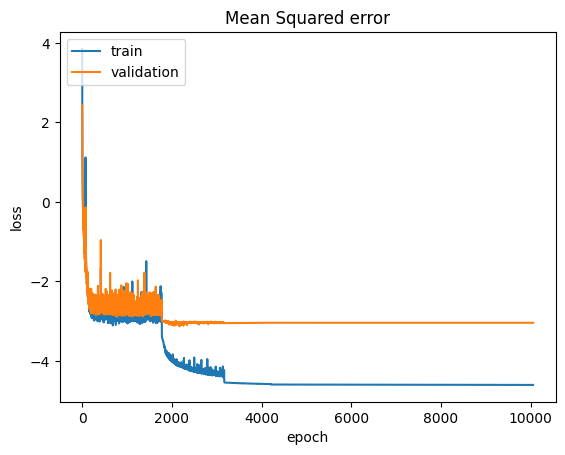

In [ ]:
# summarize history for loss

loss=[]
val_loss=[]
for ii in range(len(epochs_values)):

  loss+=epochs_values[ii].history['loss']
  val_loss+=epochs_values[ii].history['val_loss']

loss=N.asarray(loss)
val_loss=N.asarray(val_loss)

plt.plot(N.log10(loss))
plt.plot(N.log10(val_loss))
#plt.plot(loss)
#plt.plot(val_loss)
plt.title('Mean Squared error')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')
plt.show()

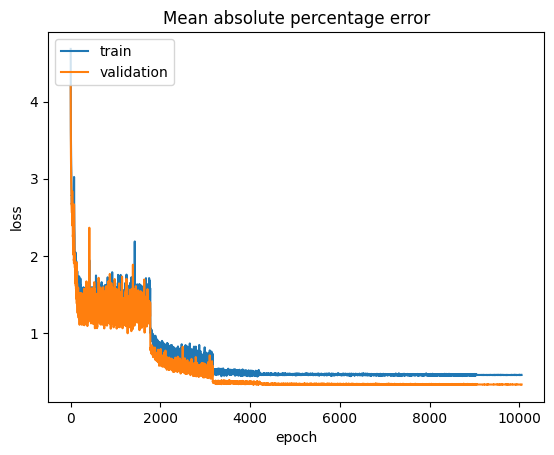

In [ ]:
# summarize history for Mean absolute percentage error

loss=[]
val_loss=[]
for ii in range(len(epochs_values)):

  loss+=epochs_values[ii].history['mape']
  val_loss+=epochs_values[ii].history['val_mape']

loss=N.asarray(loss)
val_loss=N.asarray(val_loss)

plt.plot(N.log10(loss))
plt.plot(N.log10(val_loss))

#plt.plot(loss)
#plt.plot(val_loss)
plt.title('Mean absolute percentage error')
plt.ylabel('loss')
plt.xlabel('epoch')



plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predeict the values of the test set, de-normalize everything and compute the mean percent error of all test set points. We also make an histogram of mean percent error

157/157 [==============================] - 0s 606us/step
Mean Mean % error= 0.03896714532778668


(array([2944.,  774.,  380.,  187.,  143.,   91.,   60.,   61.,   33.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 <BarContainer object of 9 artists>)

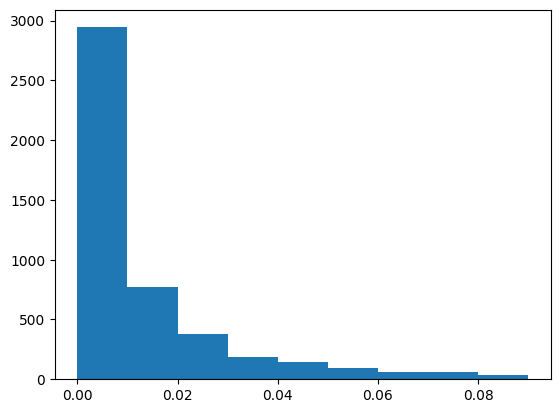

In [ ]:
#this predicts the multipole of the parameters in the test set
multipole_modelled_normed = model.predict(param_test_norm)

#We remove the normalisation and the hiperbolic sin
multipole_modelled=multipole_modelled_normed*input_std+input_mean
multipole_modelled_nonorm=N.sinh(multipole_modelled)*multi_std


#Compute the percent error of all points in the test set
N_param=len(multipole_modelled_nonorm[0])
Percent_error=[N.mean(N.abs((multipole_modelled_nonorm[ii]-multipole_test[ii])/multipole_test[ii])) for ii in range(len(multipole_modelled_nonorm))]


print('Mean Mean % error=',N.mean(Percent_error))

bins=N.arange(0,0.1,0.01)
plt.hist(Percent_error,bins=bins)

In [ ]:
param_test_norm.shape

(5000, 10)

In [ ]:
multipole_test.shape

(5000, 31)

In [ ]:
multipole_test.shape

(5000, 31)

# Let us plot the percentile error plot. At a given r line, x% of the test set points have a smaller error than the line.

In [ ]:
rbin

array([ 22.,  26.,  30.,  34.,  38.,  42.,  46.,  50.,  54.,  58.,  62.,
        66.,  70.,  74.,  78.,  82.,  86.,  90.,  94.,  98., 102., 106.,
       110., 114., 118., 122., 126., 130., 134., 138., 142.])

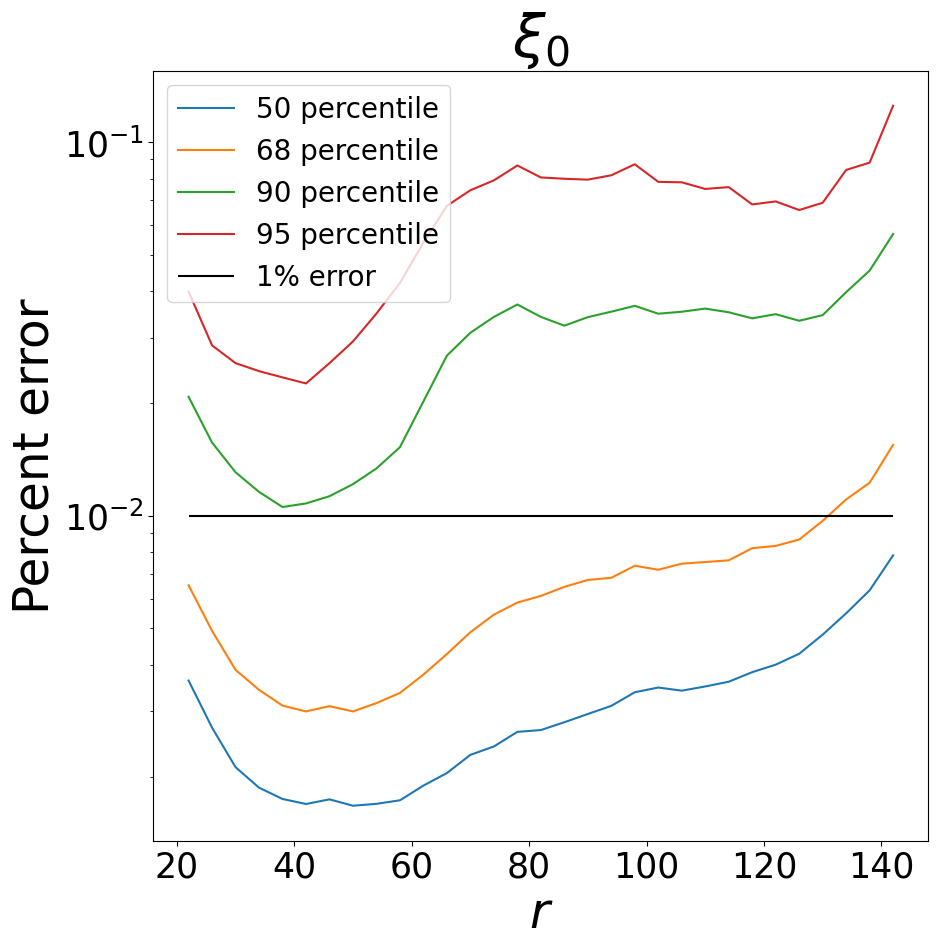

In [ ]:
bin_error=N.array([N.abs((multipole_modelled_nonorm[:,ii]-multipole_test[:,ii])/multipole_test[:,ii]) for ii in range(N_bins)])

percent_50=N.zeros(N_bins)
percent_68=N.zeros(N_bins)
percent_90=N.zeros(N_bins)
percent_95=N.zeros(N_bins)

for ii in range(N_bins):
      percent_50[ii]=N.percentile(bin_error[ii],50)
      percent_68[ii]=N.percentile(bin_error[ii],68)
      percent_90[ii]=N.percentile(bin_error[ii],90)
      percent_95[ii]=N.percentile(bin_error[ii],95)
plt.figure(figsize=(10,10))
plt.yscale('log') 
plt.title(r'$\xi _0$',fontsize=42)
plt.plot(rbin,percent_50,label='50 percentile')
plt.plot(rbin,percent_68,label='68 percentile')
plt.plot(rbin,percent_90,label='90 percentile')
plt.plot(rbin,percent_95,label='95 percentile')
plt.xlabel('$r$',fontsize=35)
plt.hlines(0.01,xmin=rbin[0],xmax=rbin[-1],color='black',label='1% error')
plt.legend(fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Percent error',fontsize=35)
plt.savefig(name_plot, bbox_inches='tight')


# This is the model with the worst mean percent error all of the test set.

<Figure size 640x480 with 0 Axes>

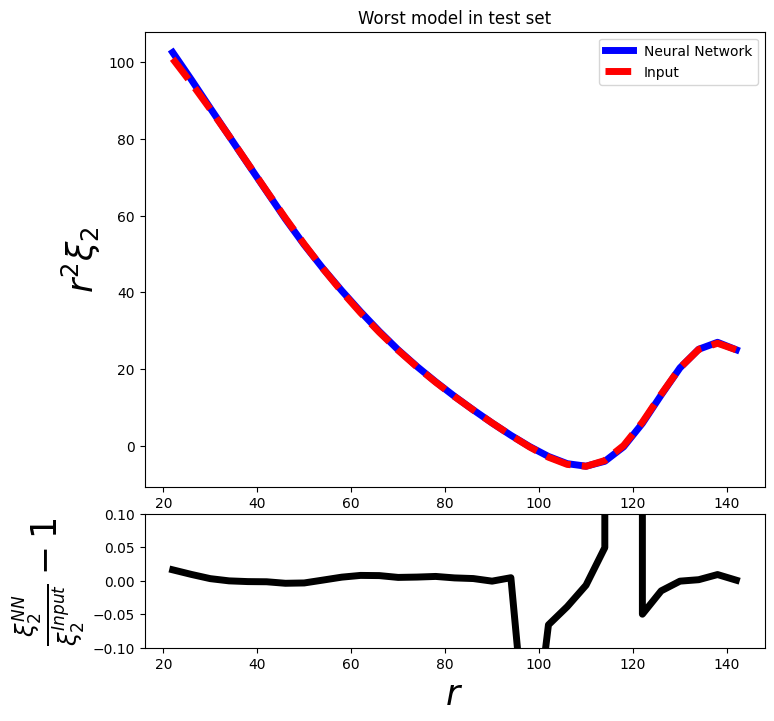

In [ ]:
Worst_index=N.where(max(Percent_error)==Percent_error)[0][0]

plt.clf() 

graf=plt.figure(figsize=(8,8))
gs=plt.GridSpec(4,4)
g1=graf.add_subplot(gs[:3,:])
g2=graf.add_subplot(gs[3,:])
g2.set_ylim([-0.1,0.1])
g1.set_title('Worst model in test set')
g2.set_xlabel(r'$r$',fontsize=25)
g1.set_ylabel(r'$r^2\xi_2$',fontsize=25) 
g2.set_ylabel(r'$\frac{\xi^{NN}_2}{\xi^{Input}_2}-1$',fontsize=25) 
g1.plot(rbin,rbin**2*multipole_modelled_nonorm[Worst_index],color='blue',label='Neural Network',linewidth=5)
g1.plot(rbin,rbin**2*multipole_test[Worst_index],'--',color='red',label='Input',linewidth=5)
g2.plot(rbin,(multipole_modelled_nonorm[Worst_index]/multipole_test[Worst_index])-1.0,color='black',linewidth=5)
g1.legend()
plt.show() 

# Plot the first 50 modells of the test set

<Figure size 640x480 with 0 Axes>

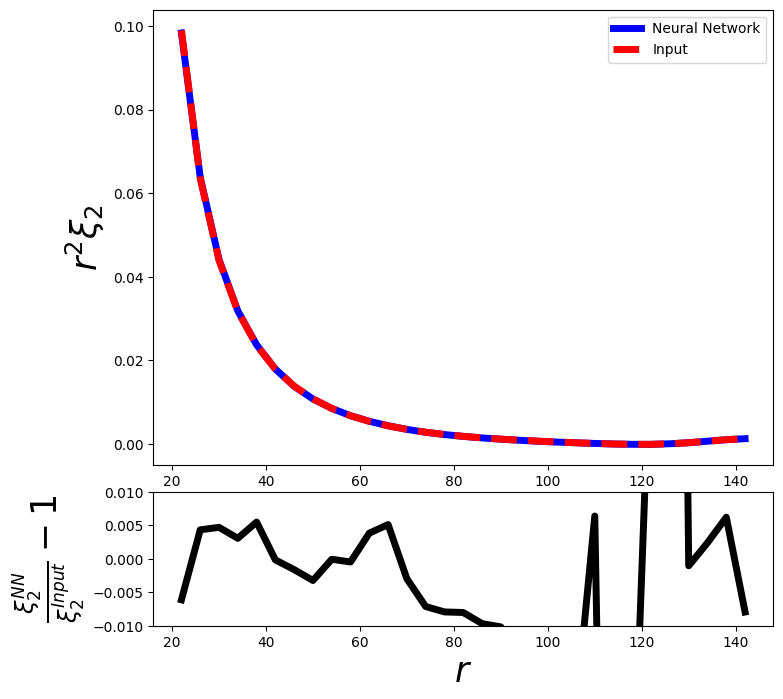

<Figure size 640x480 with 0 Axes>

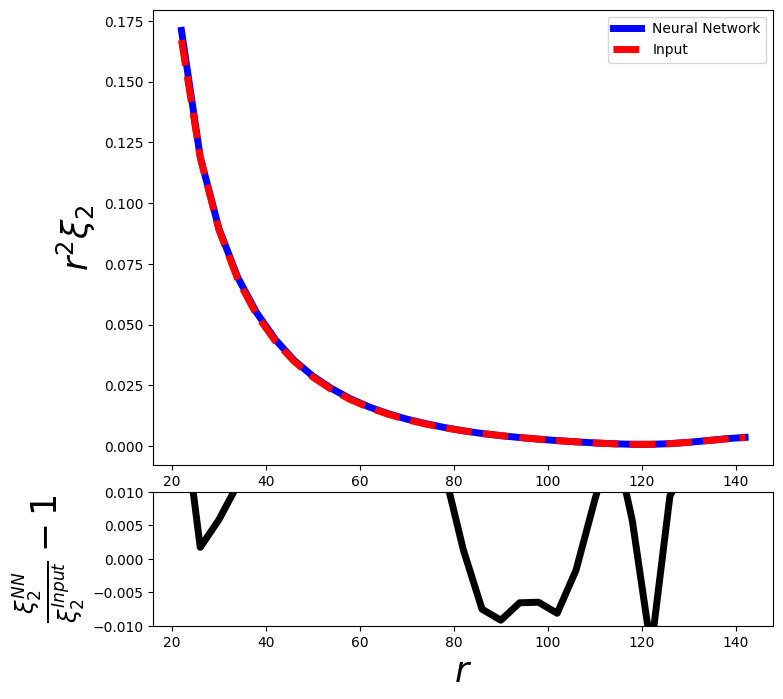

<Figure size 640x480 with 0 Axes>

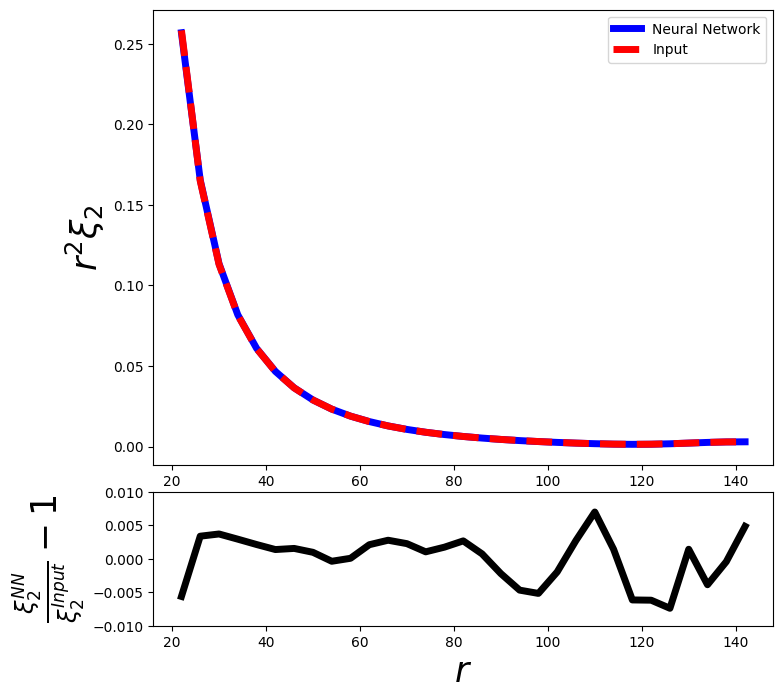

<Figure size 640x480 with 0 Axes>

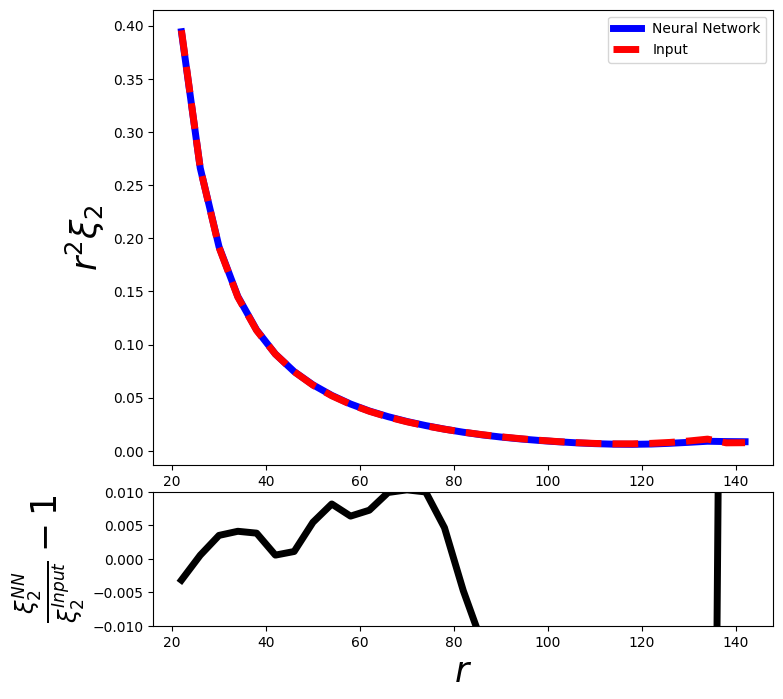

<Figure size 640x480 with 0 Axes>

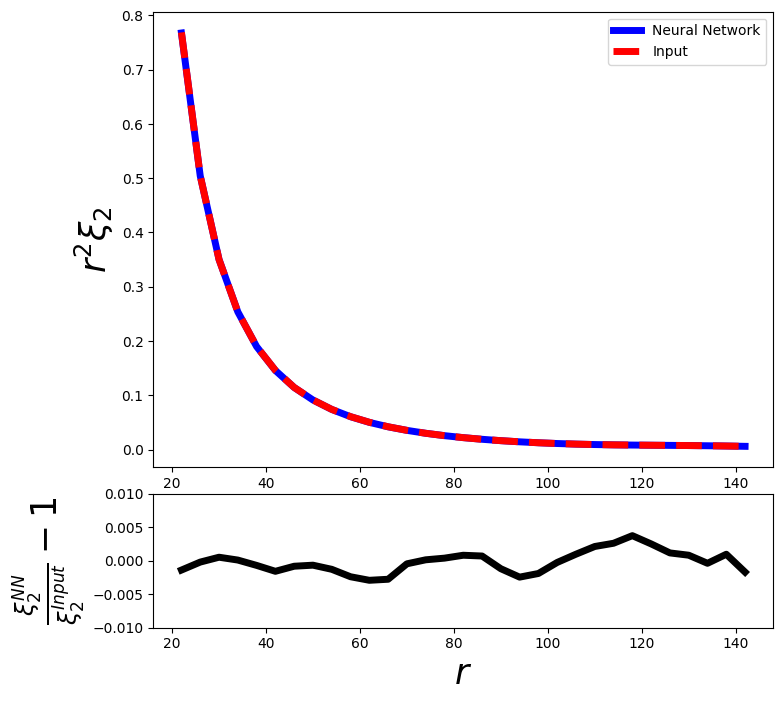

<Figure size 640x480 with 0 Axes>

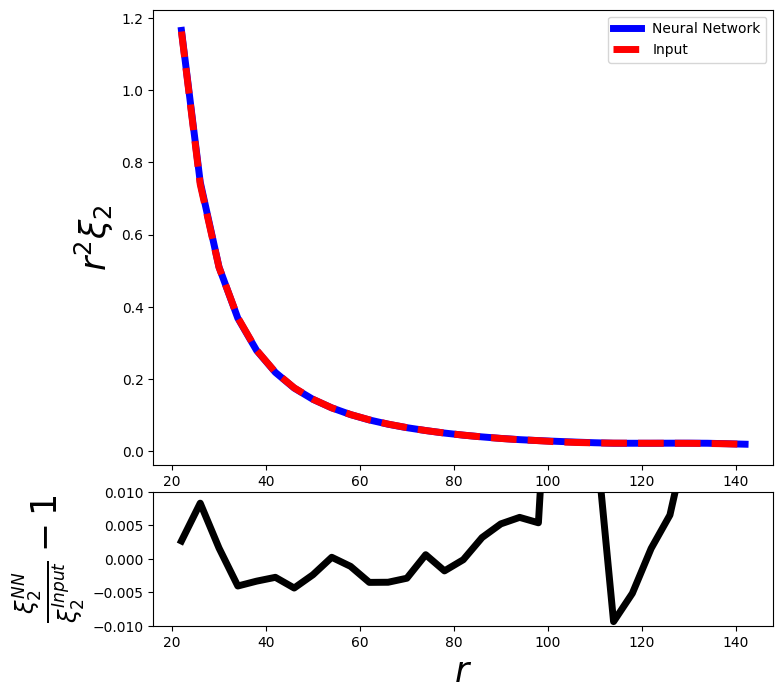

<Figure size 640x480 with 0 Axes>

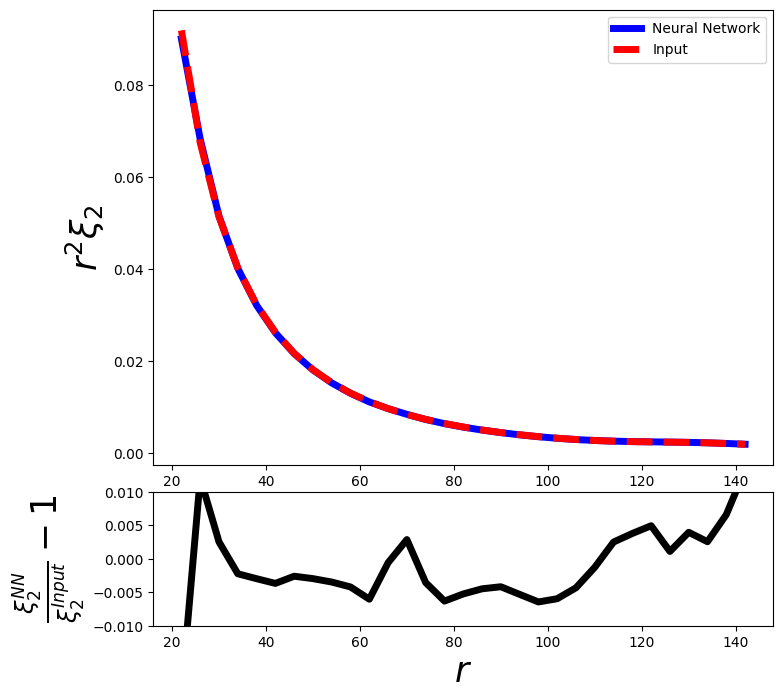

<Figure size 640x480 with 0 Axes>

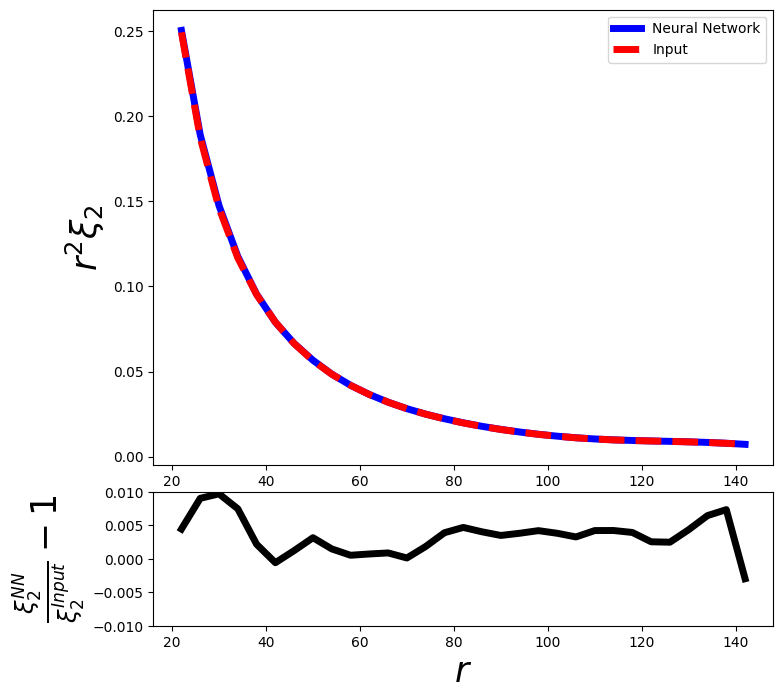

<Figure size 640x480 with 0 Axes>

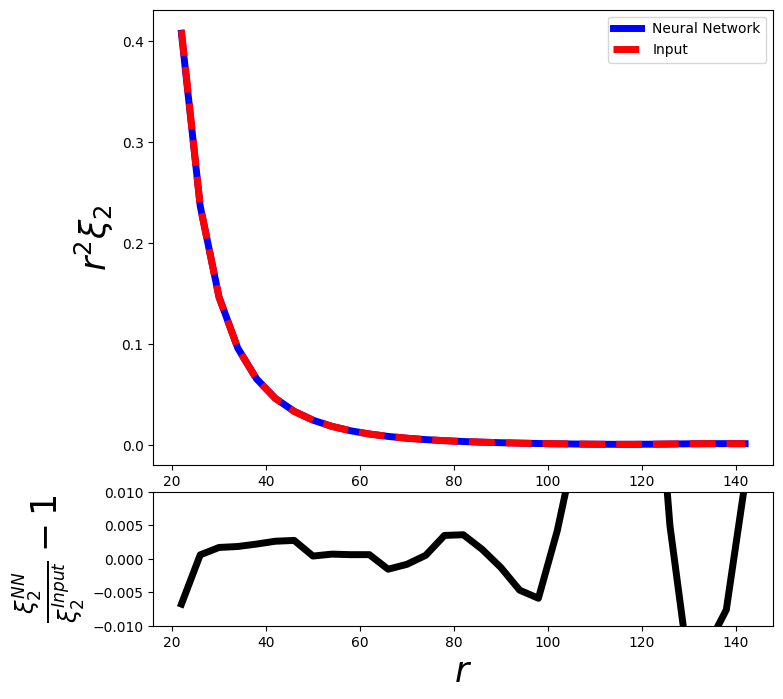

<Figure size 640x480 with 0 Axes>

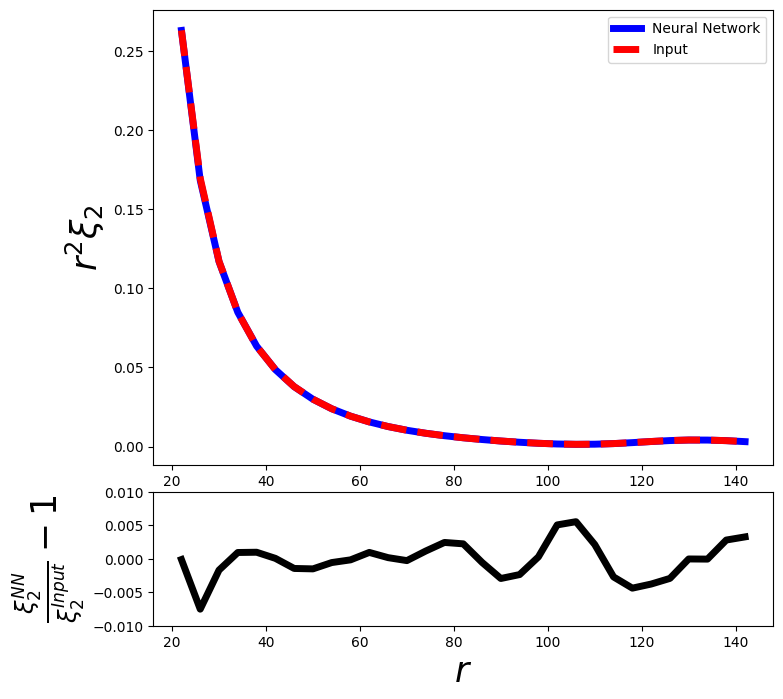

<Figure size 640x480 with 0 Axes>

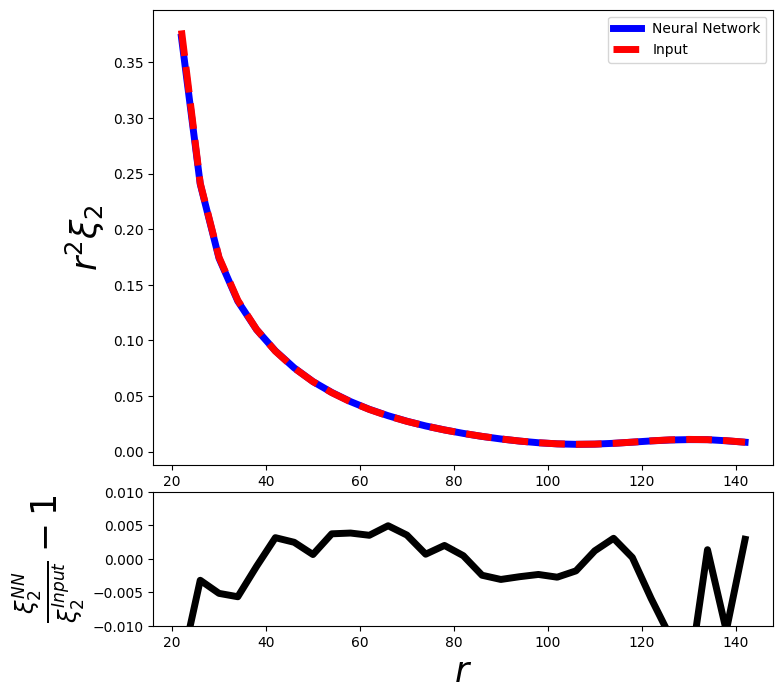

<Figure size 640x480 with 0 Axes>

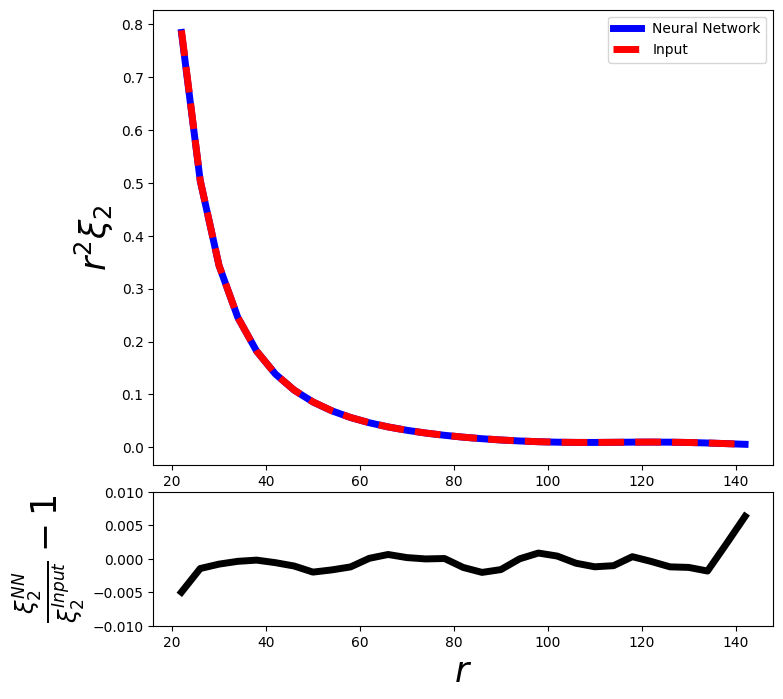

<Figure size 640x480 with 0 Axes>

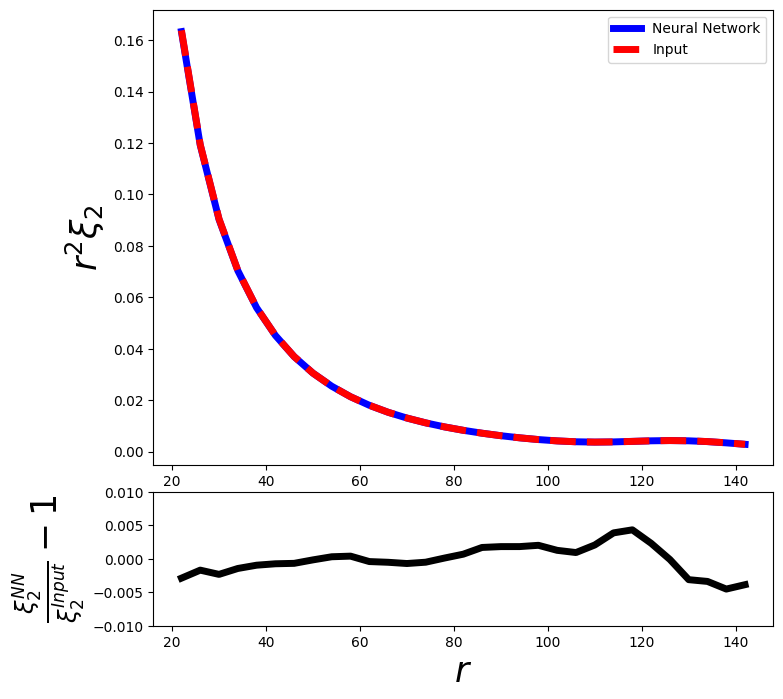

<Figure size 640x480 with 0 Axes>

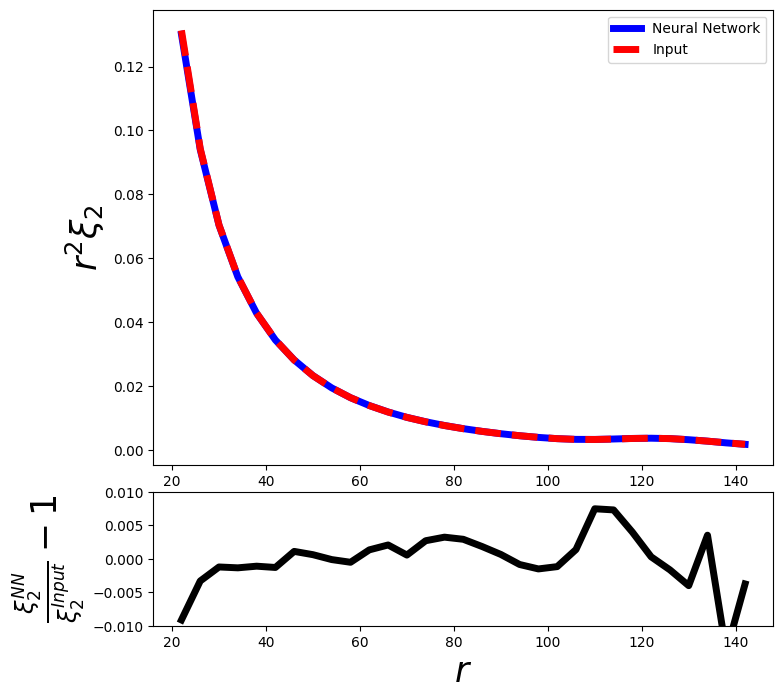

<Figure size 640x480 with 0 Axes>

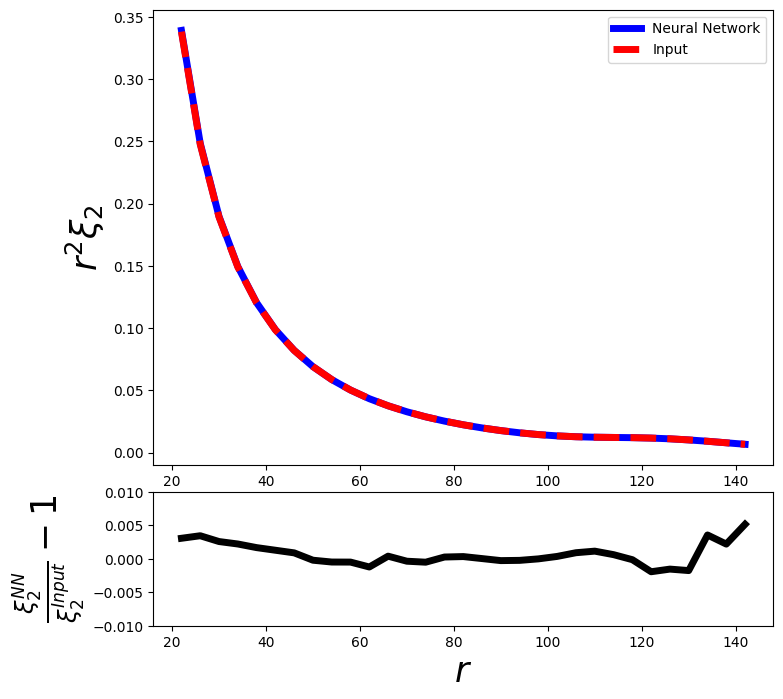

<Figure size 640x480 with 0 Axes>

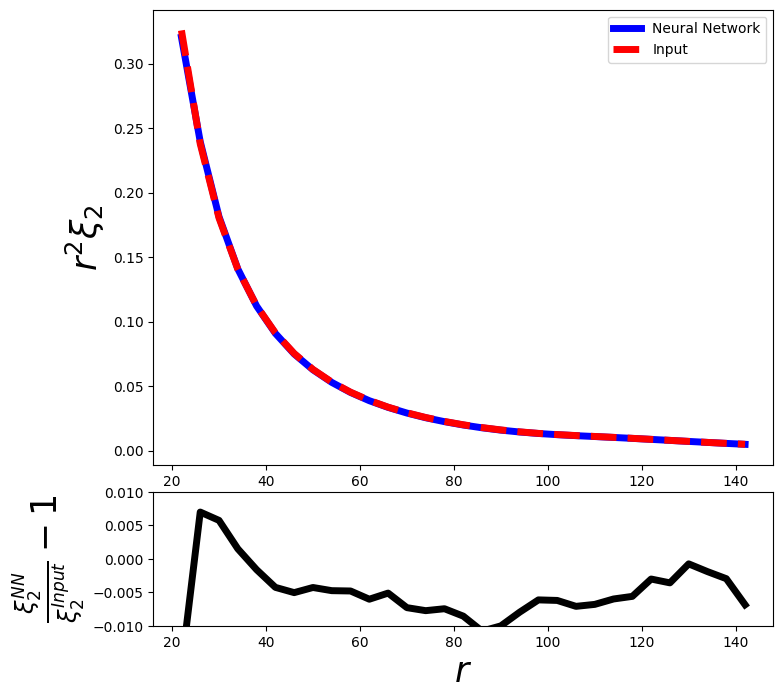

<Figure size 640x480 with 0 Axes>

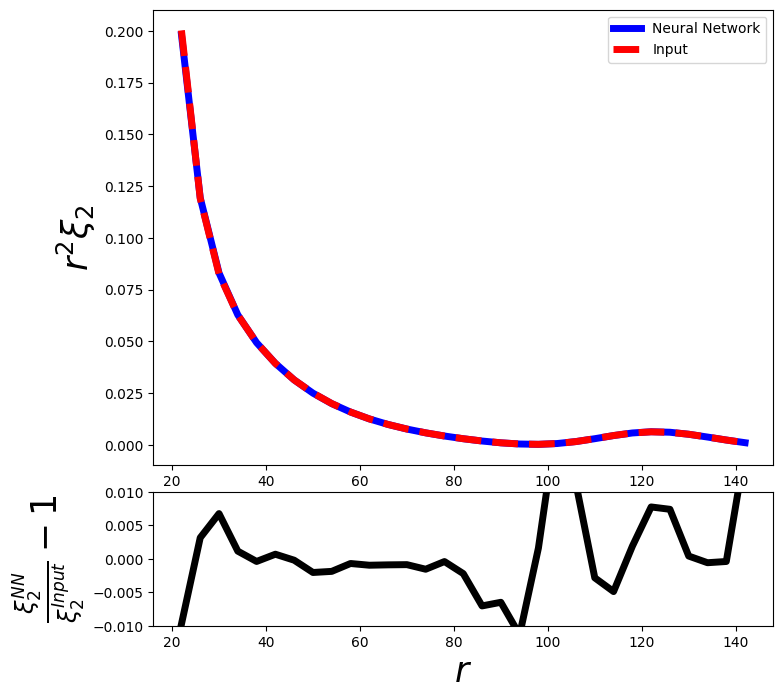

<Figure size 640x480 with 0 Axes>

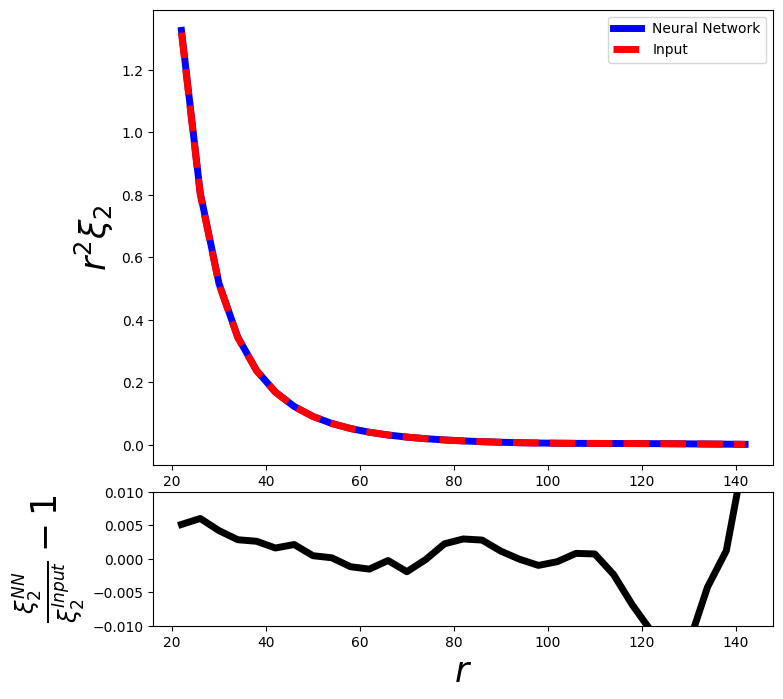

<Figure size 640x480 with 0 Axes>

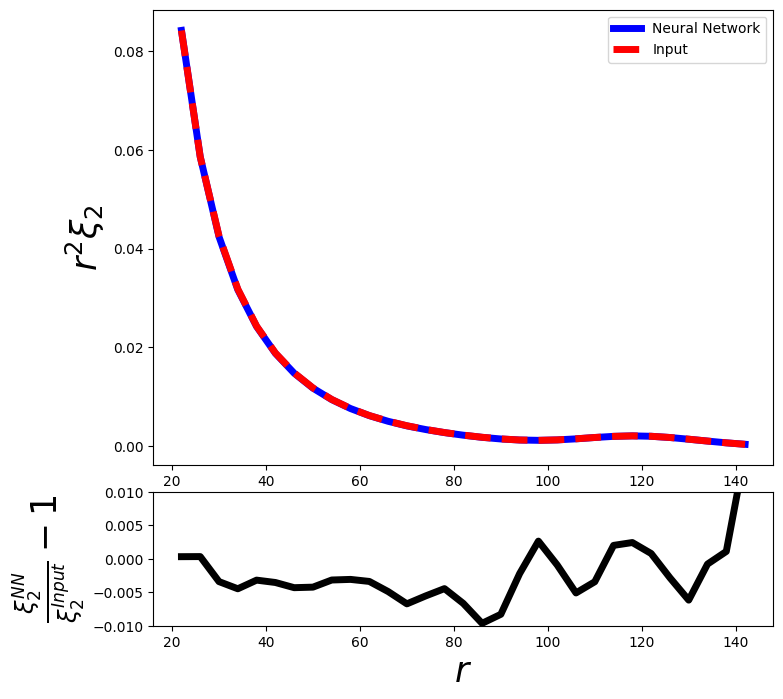

<Figure size 640x480 with 0 Axes>

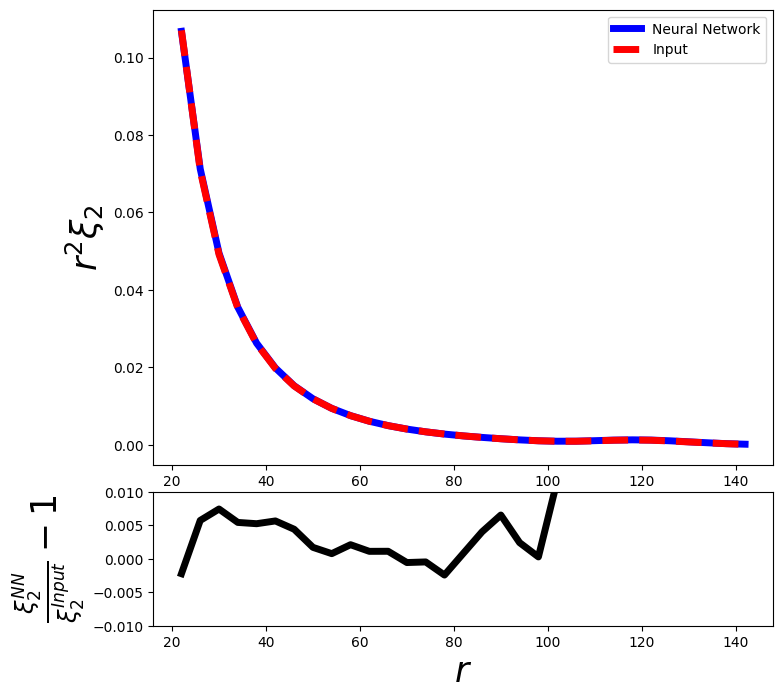

<Figure size 640x480 with 0 Axes>

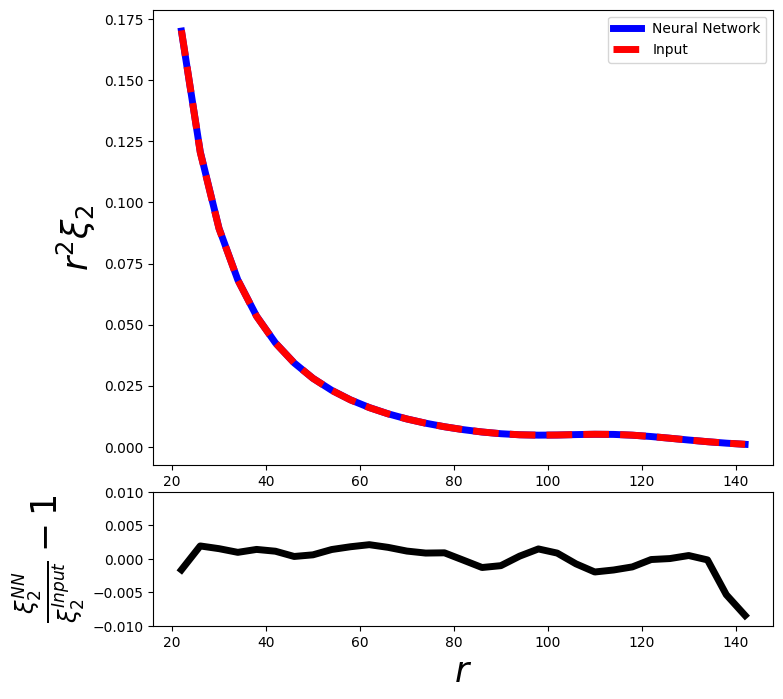

<Figure size 640x480 with 0 Axes>

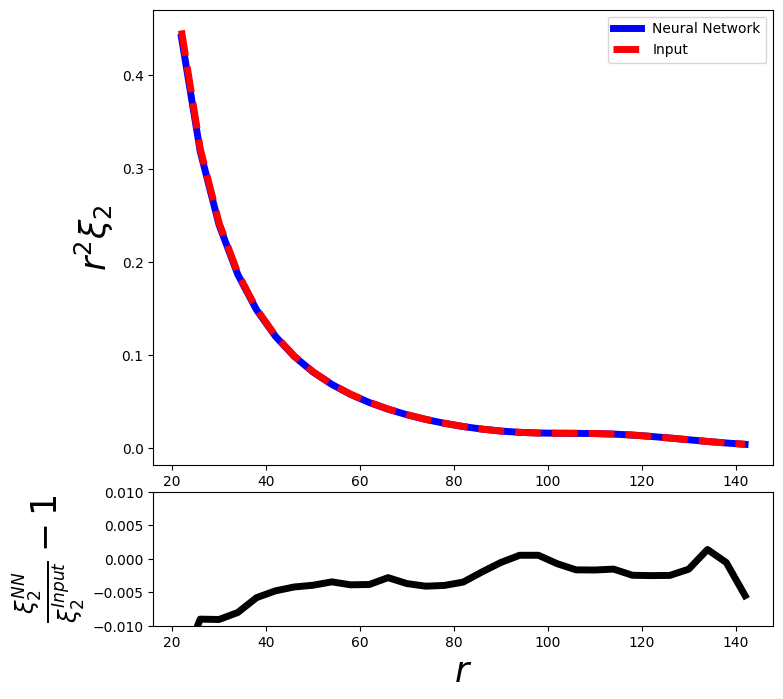

<Figure size 640x480 with 0 Axes>

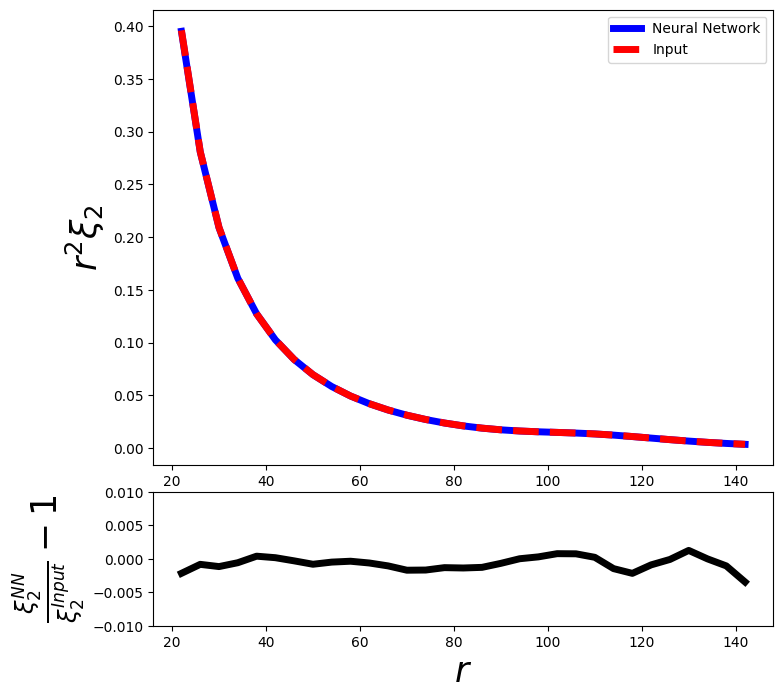

<Figure size 640x480 with 0 Axes>

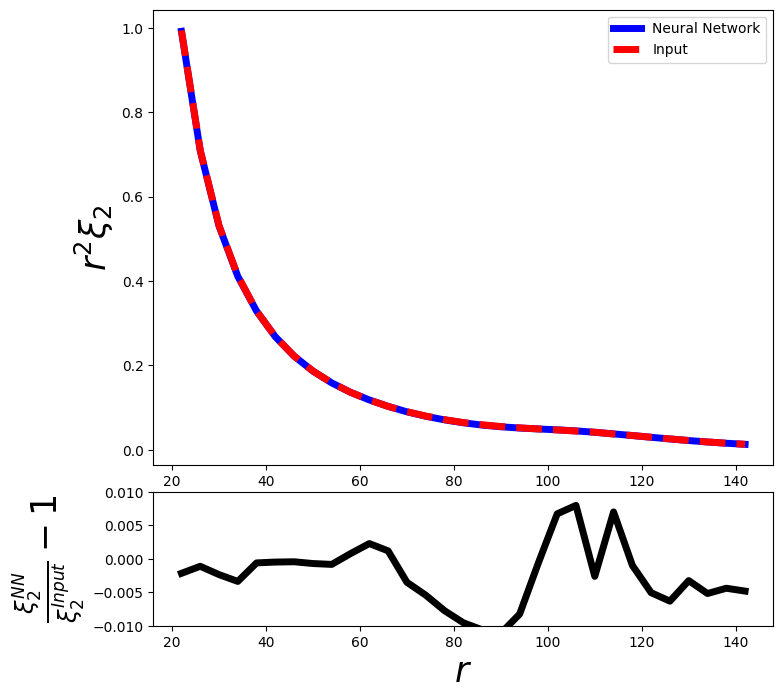

<Figure size 640x480 with 0 Axes>

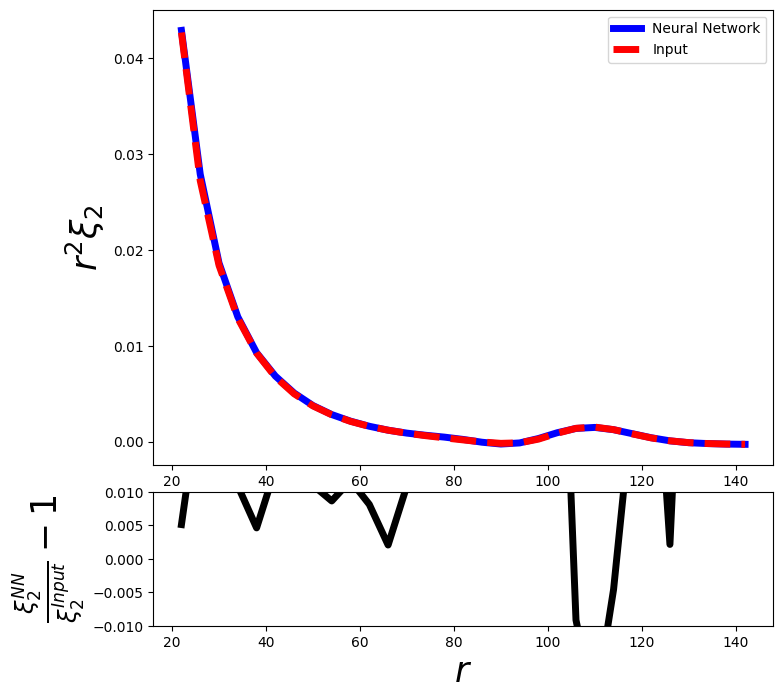

<Figure size 640x480 with 0 Axes>

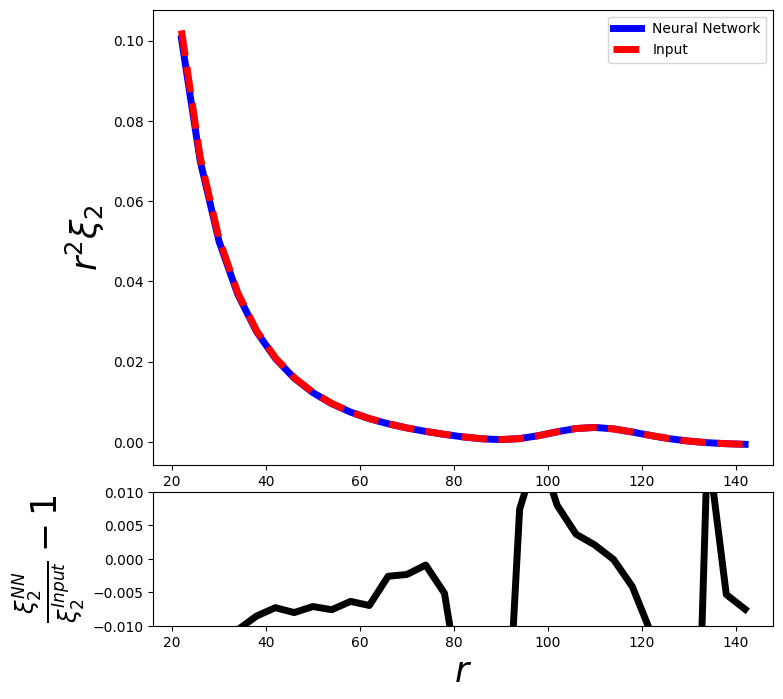

<Figure size 640x480 with 0 Axes>

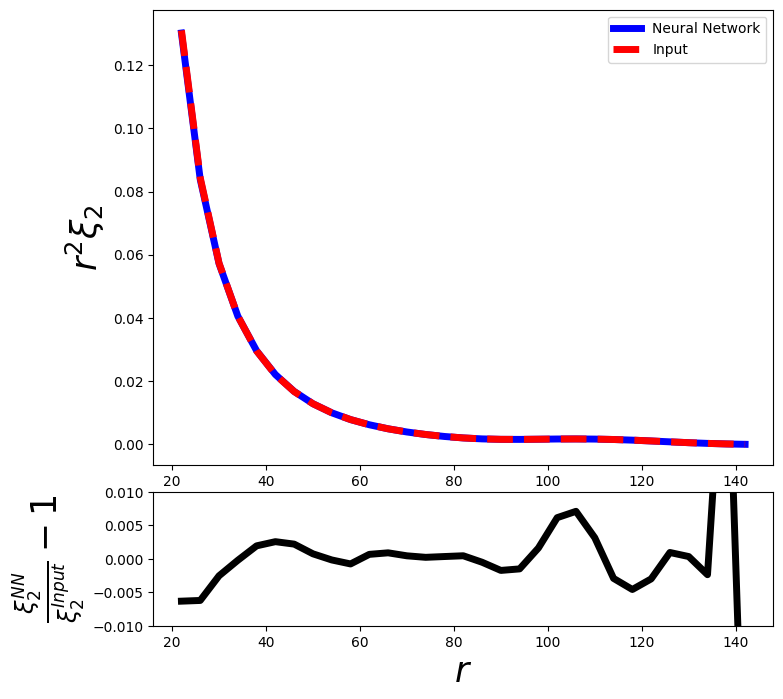

<Figure size 640x480 with 0 Axes>

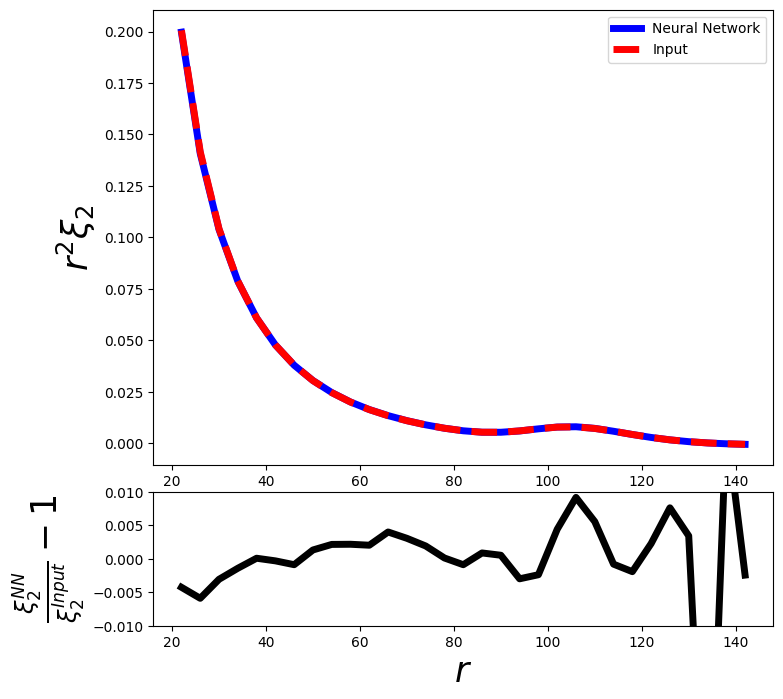

<Figure size 640x480 with 0 Axes>

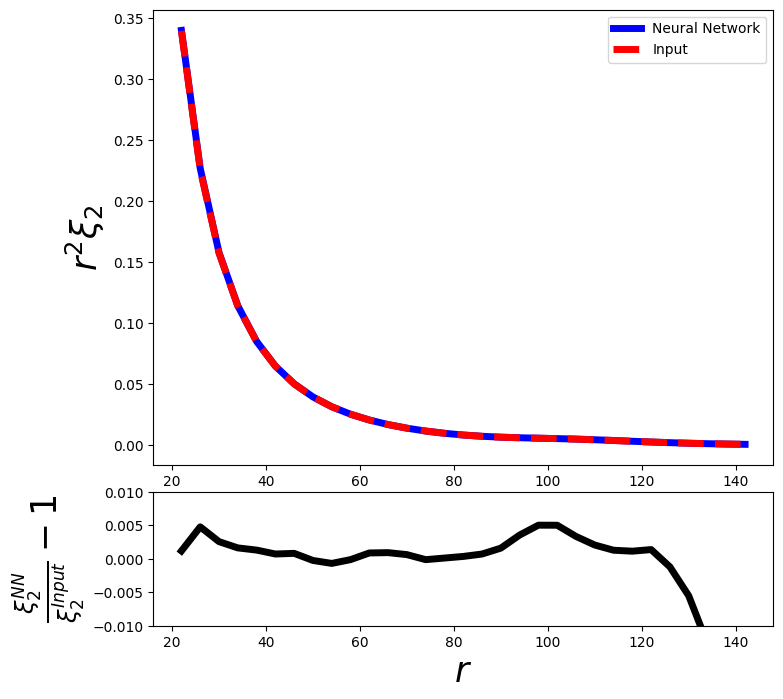

<Figure size 640x480 with 0 Axes>

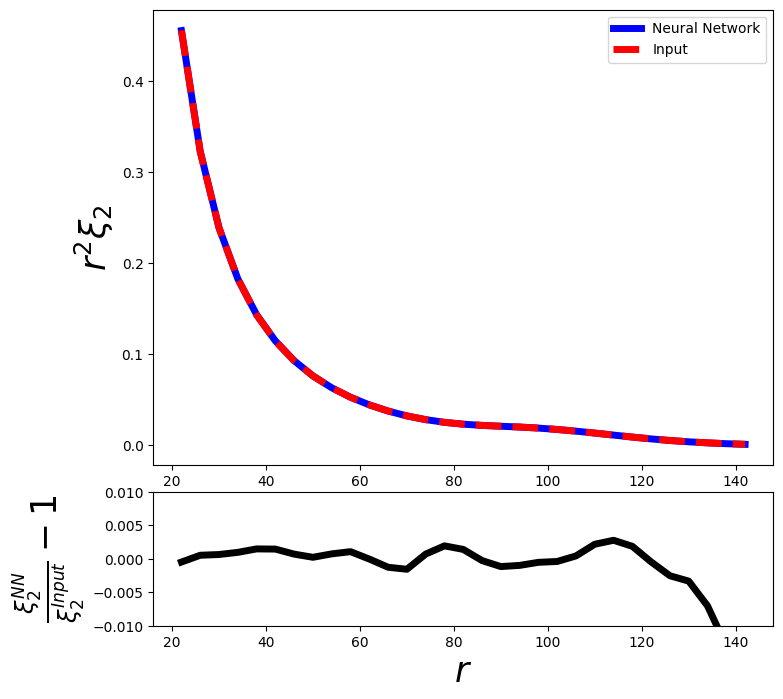

<Figure size 640x480 with 0 Axes>

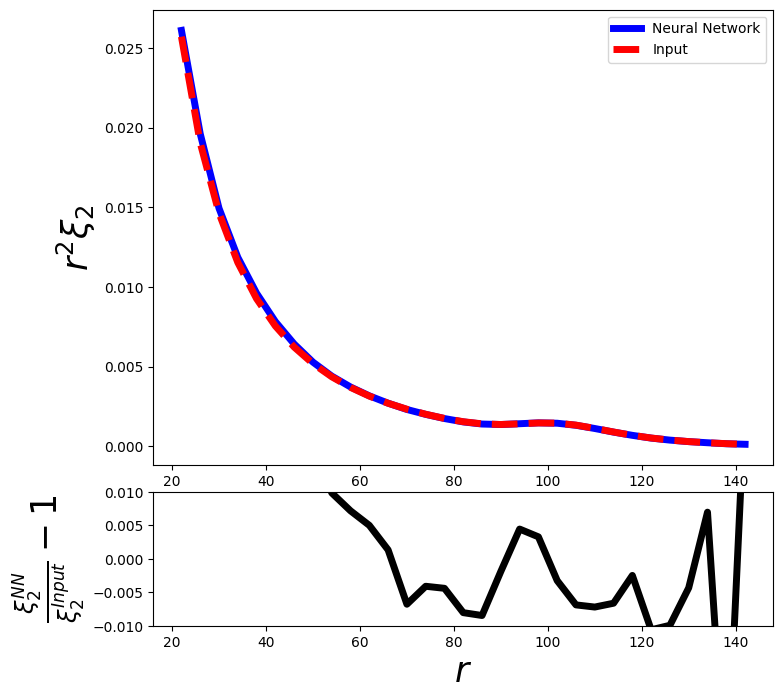

<Figure size 640x480 with 0 Axes>

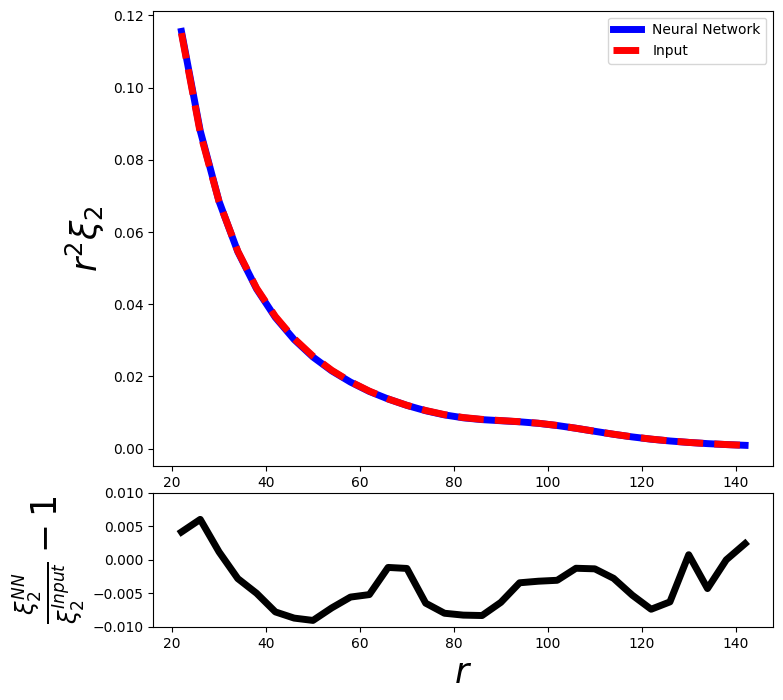

<Figure size 640x480 with 0 Axes>

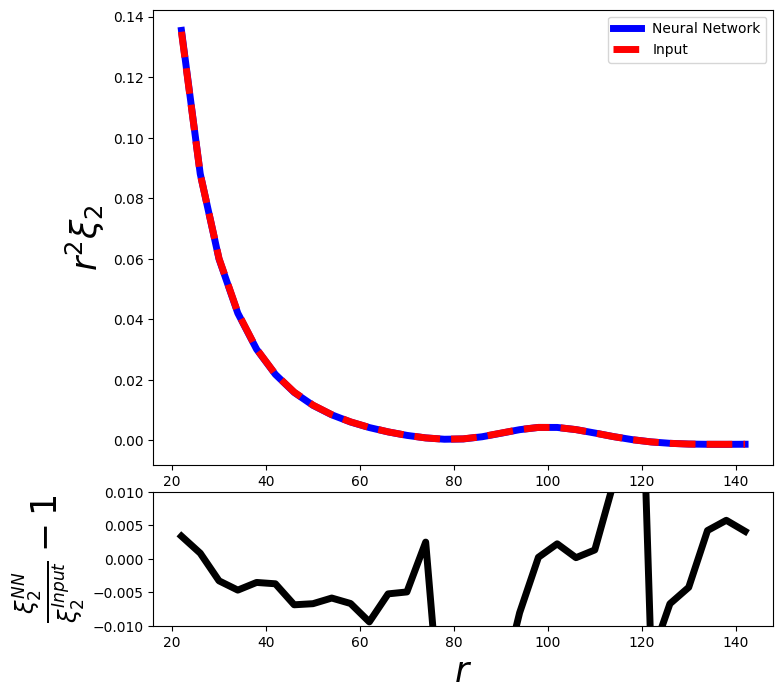

<Figure size 640x480 with 0 Axes>

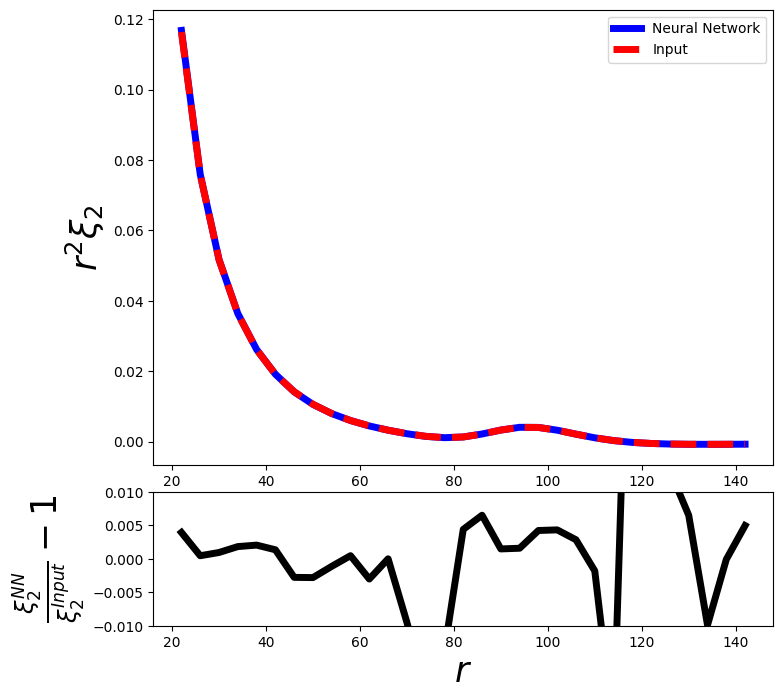

<Figure size 640x480 with 0 Axes>

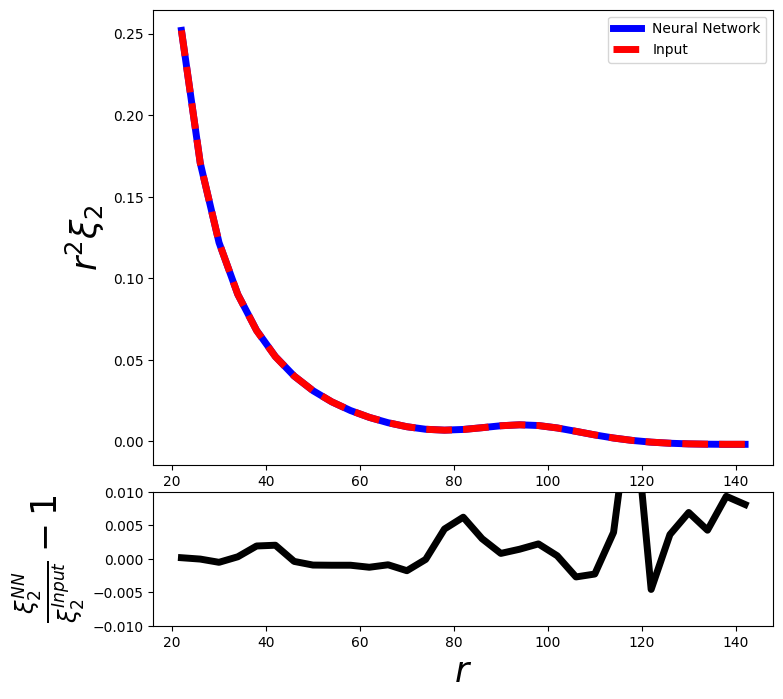

<Figure size 640x480 with 0 Axes>

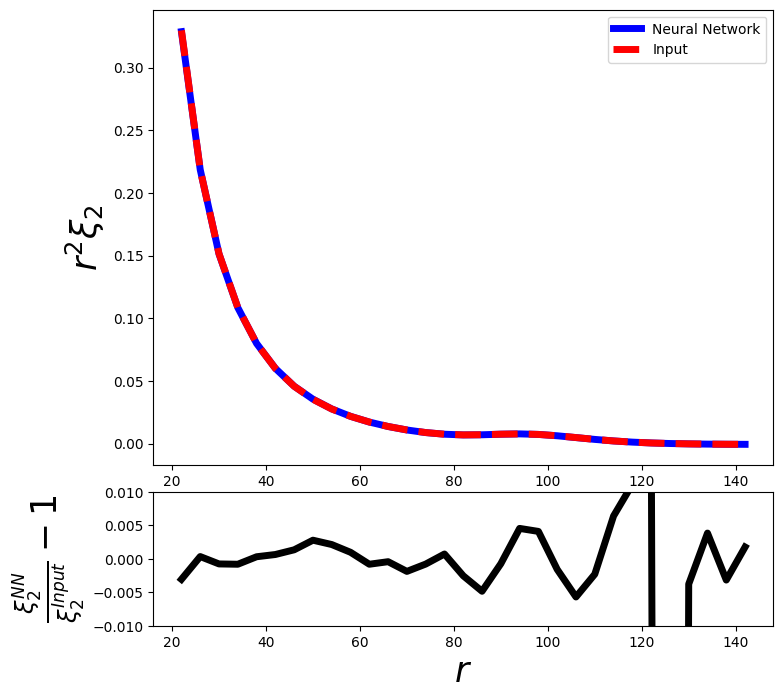

<Figure size 640x480 with 0 Axes>

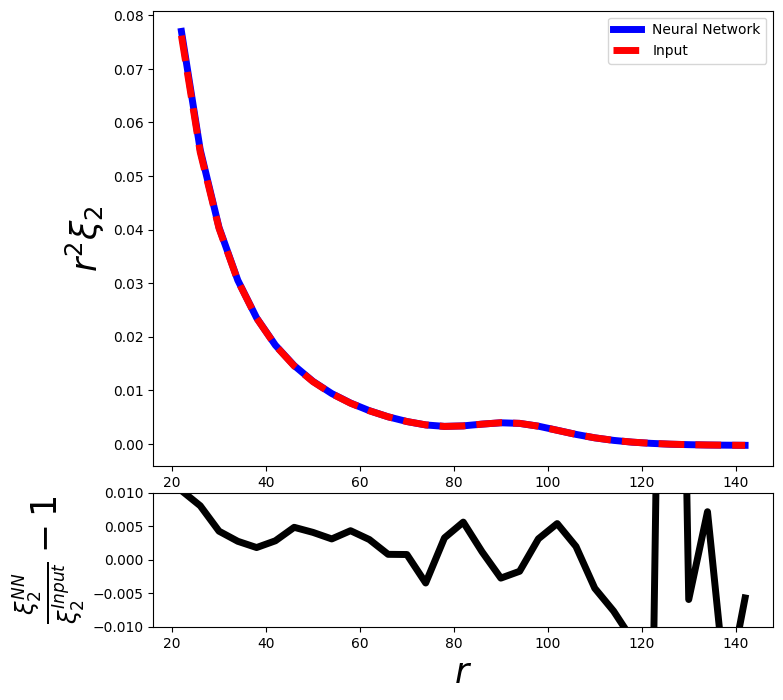

<Figure size 640x480 with 0 Axes>

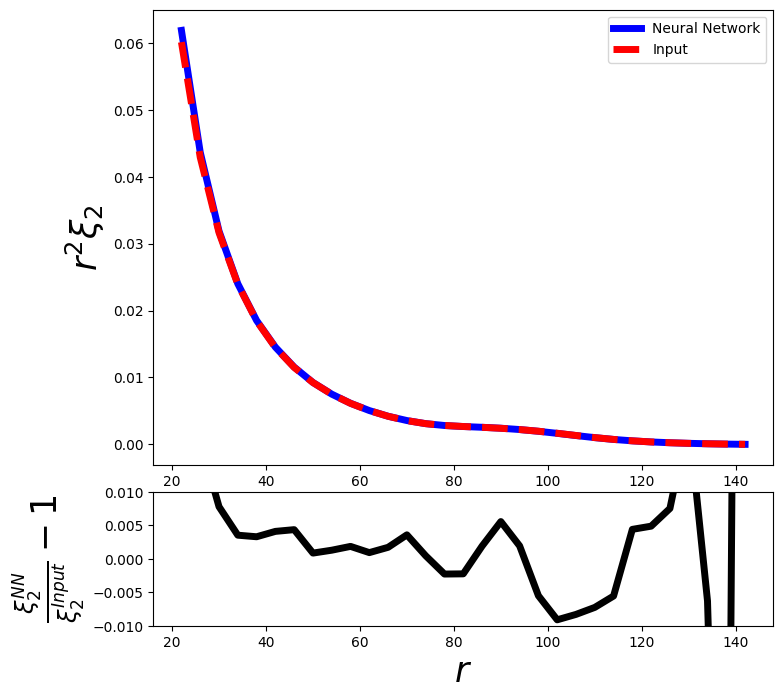

<Figure size 640x480 with 0 Axes>

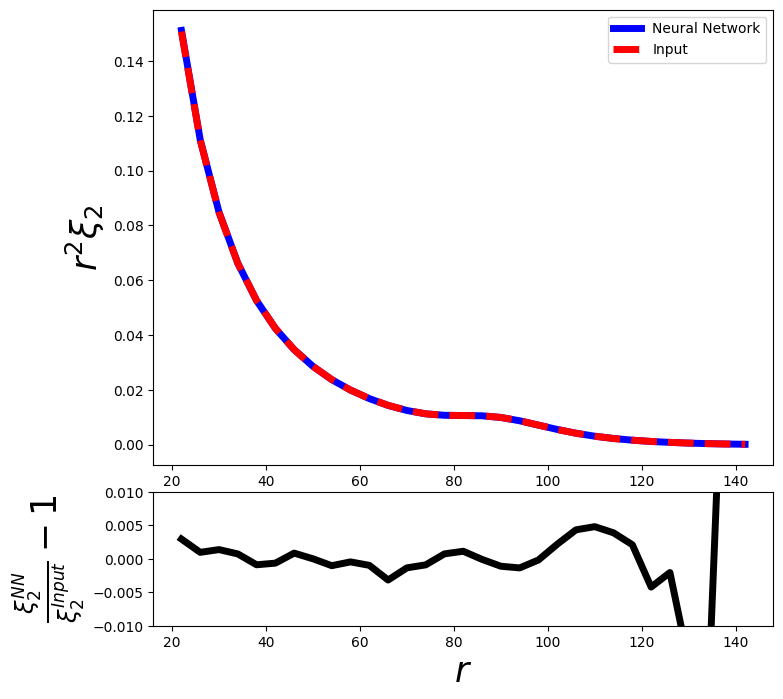

<Figure size 640x480 with 0 Axes>

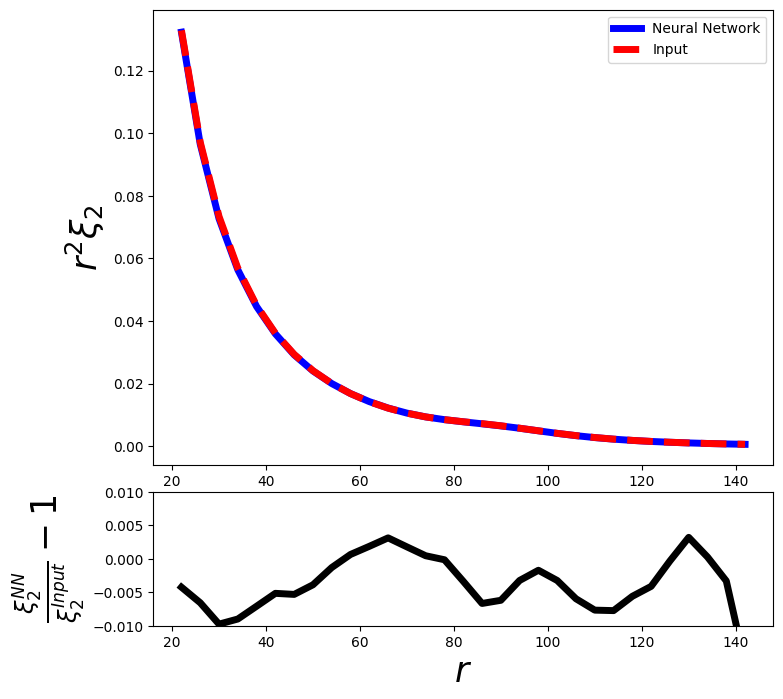

<Figure size 640x480 with 0 Axes>

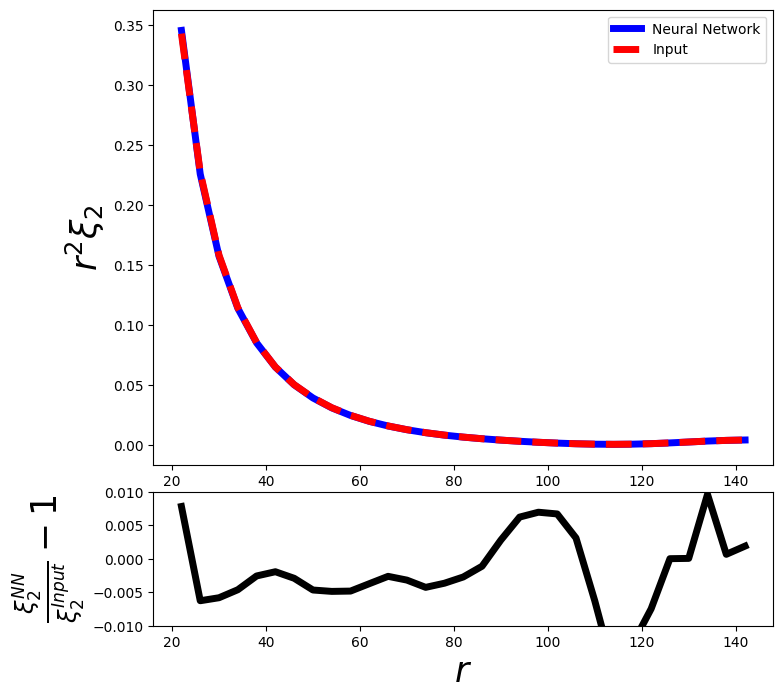

<Figure size 640x480 with 0 Axes>

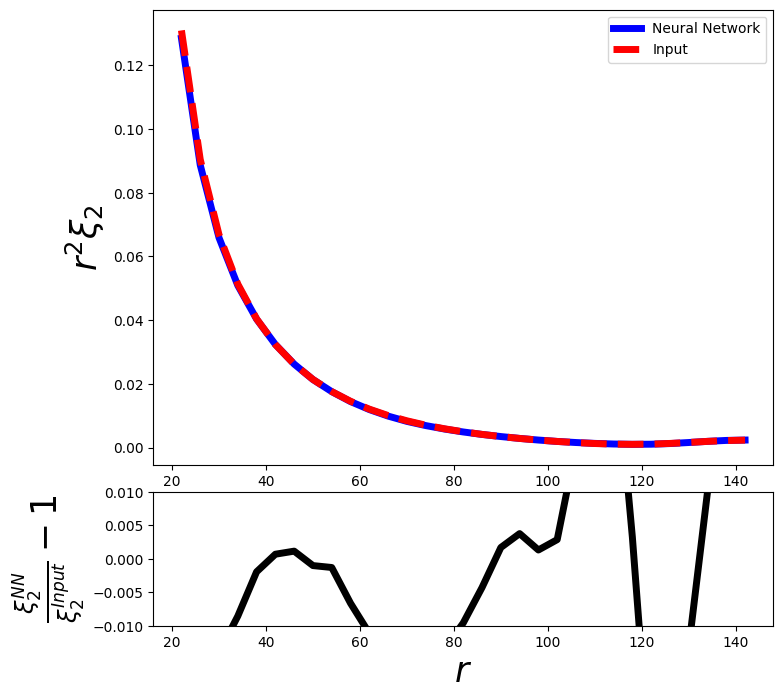

<Figure size 640x480 with 0 Axes>

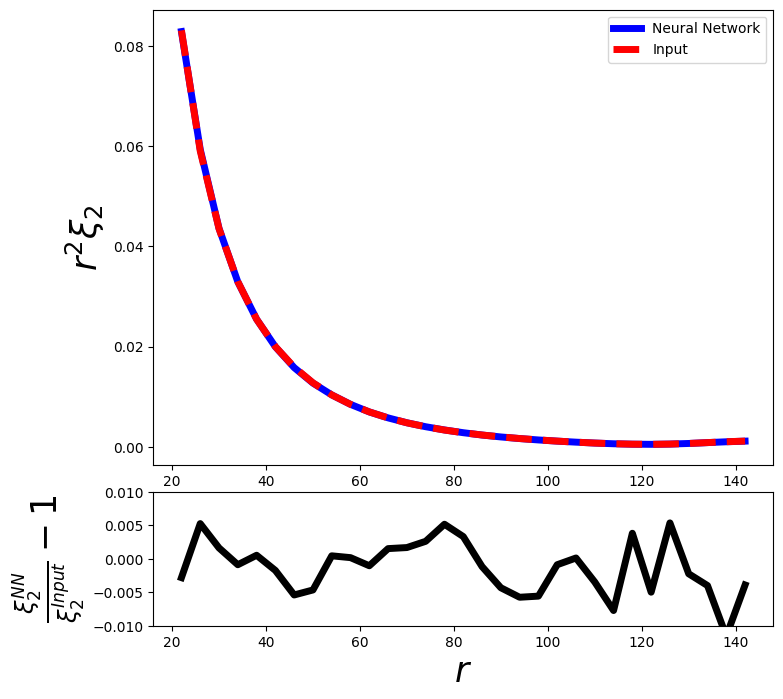

<Figure size 640x480 with 0 Axes>

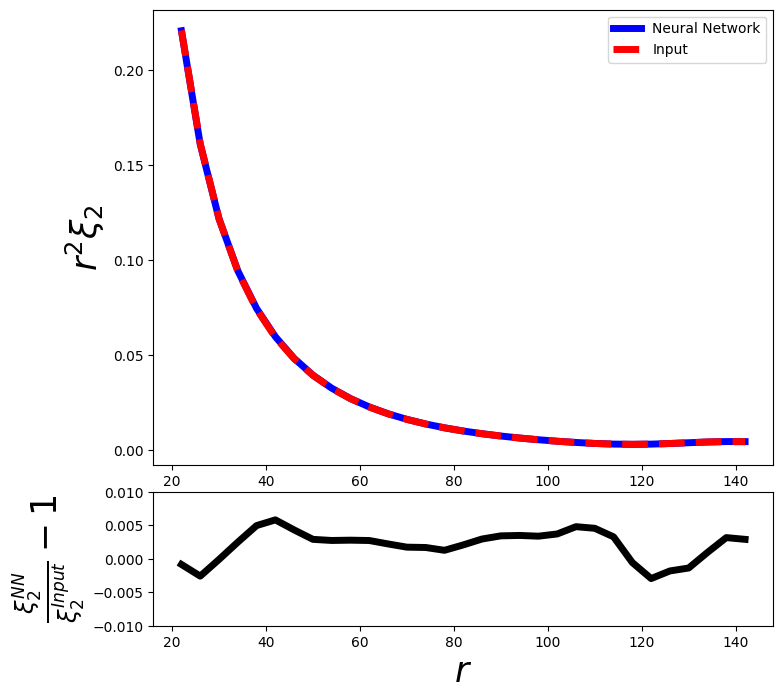

<Figure size 640x480 with 0 Axes>

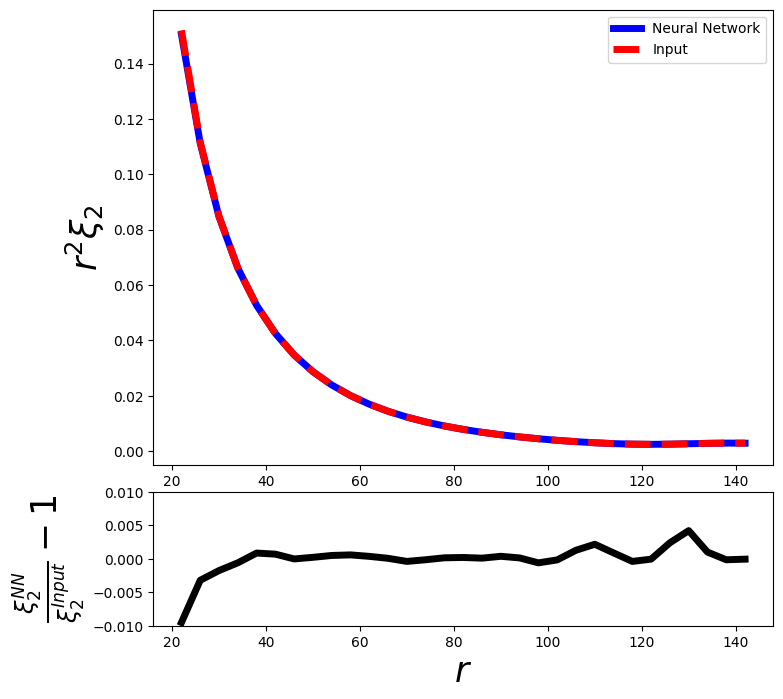

<Figure size 640x480 with 0 Axes>

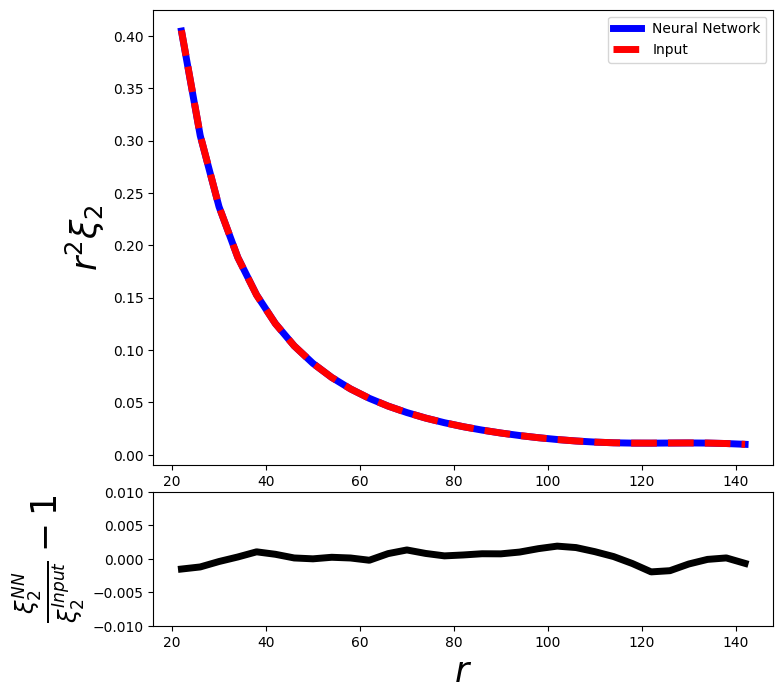

<Figure size 640x480 with 0 Axes>

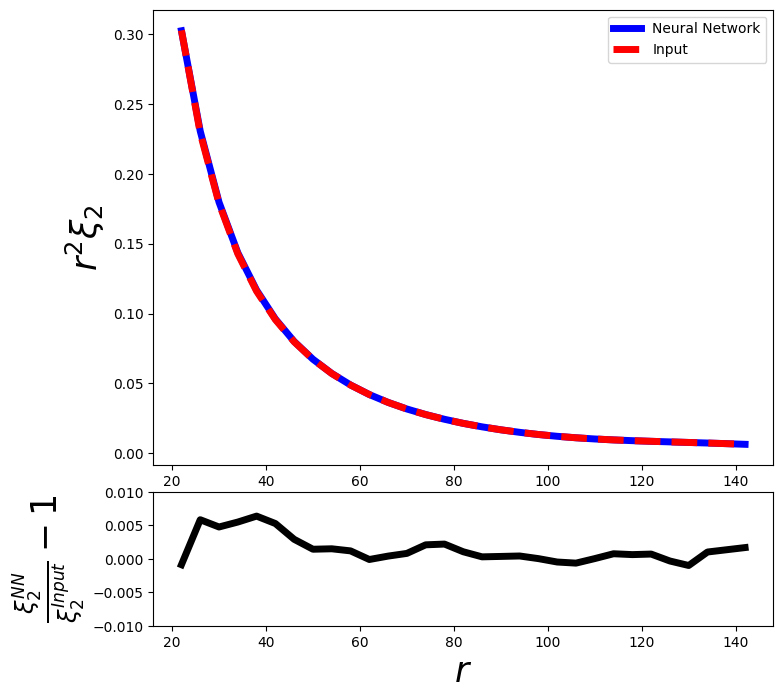

<Figure size 640x480 with 0 Axes>

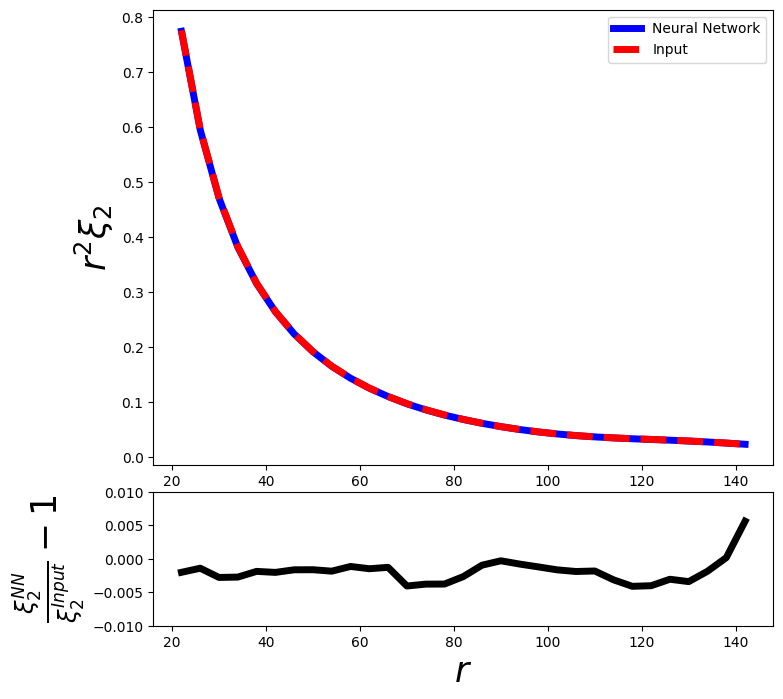

<Figure size 640x480 with 0 Axes>

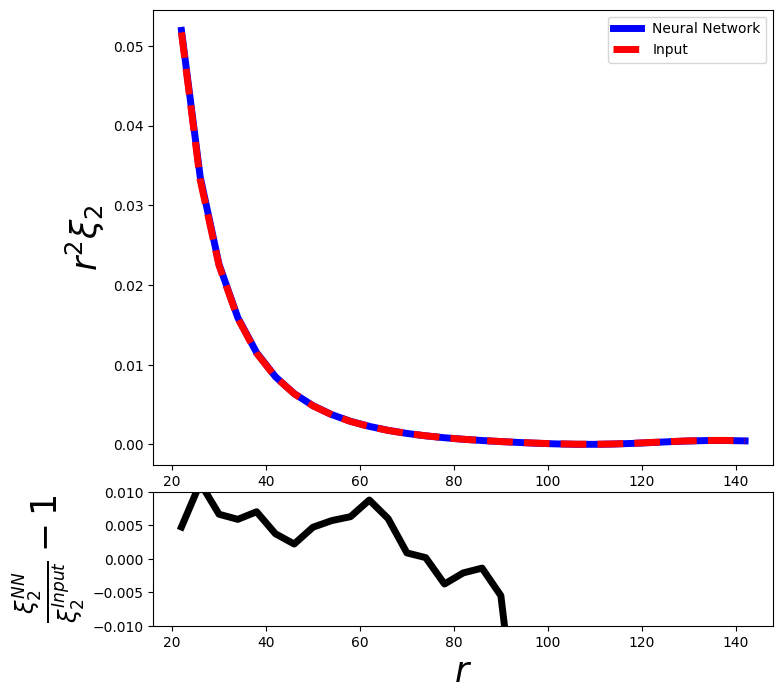

<Figure size 640x480 with 0 Axes>

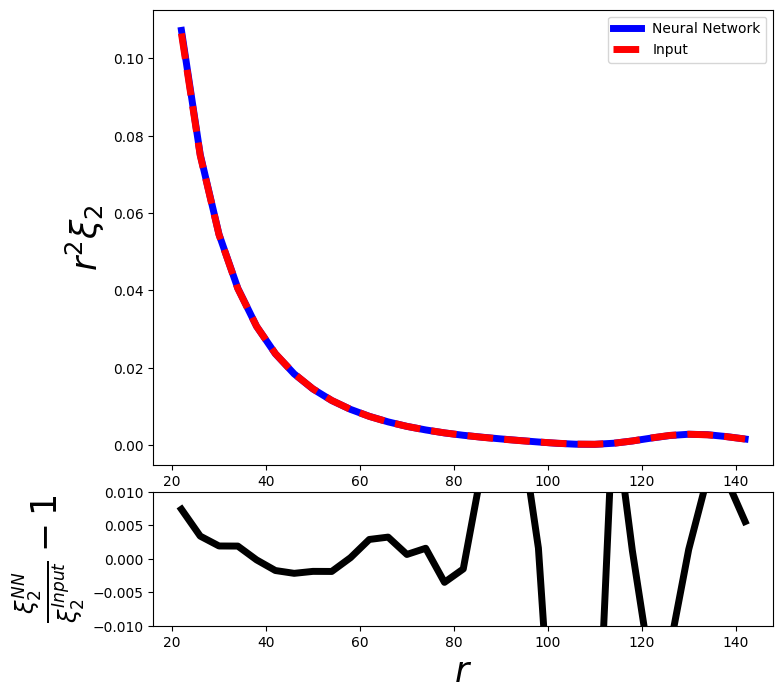

In [ ]:
for ii in range(50):

    
   plt.clf() 
   graf=plt.figure(figsize=(8,8))
   gs=plt.GridSpec(4,4)
   g1=graf.add_subplot(gs[:3,:])
   g2=graf.add_subplot(gs[3,:])
   g2.set_ylim([-0.01,0.01])
   g2.set_xlabel(r'$r$',fontsize=25)
   g1.set_ylabel(r'$r^2\xi_2$',fontsize=25) 
   g2.set_ylabel(r'$\frac{\xi^{NN}_2}{\xi^{Input}_2}-1$',fontsize=25) 
   g1.plot(rbin,multipole_modelled_nonorm[ii],color='blue',label='Neural Network',linewidth=5)
   g1.plot(rbin,multipole_test[ii],'--',color='red',label='Input',linewidth=5)
   g2.plot(rbin,(multipole_modelled_nonorm[ii]/multipole_test[ii])-1.0,color='black',linewidth=5)
   g1.legend()
   plt.show()  


<Figure size 640x480 with 0 Axes>

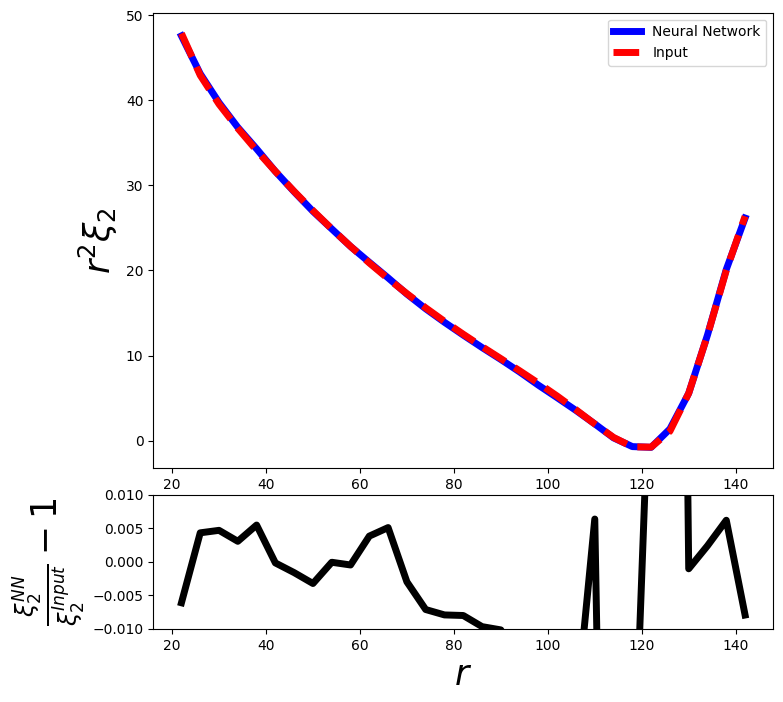

<Figure size 640x480 with 0 Axes>

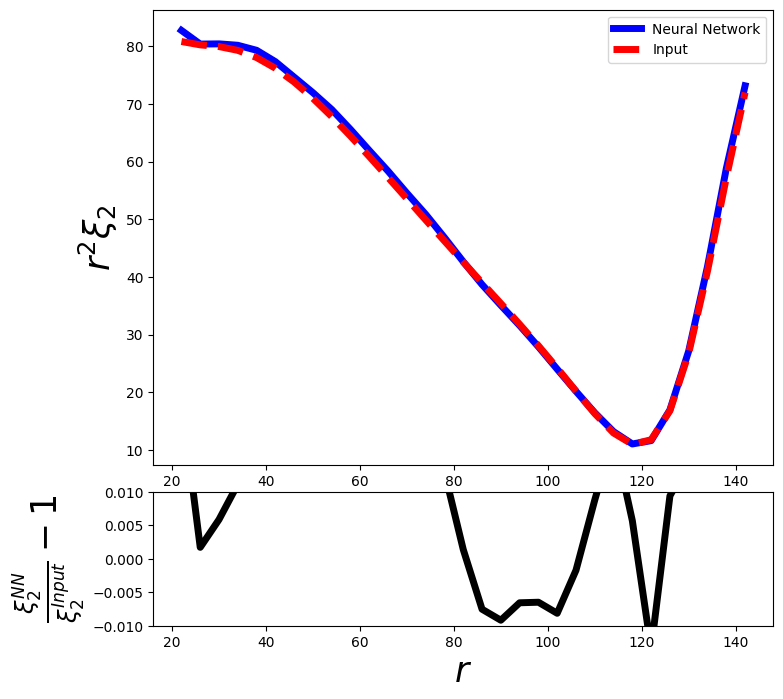

<Figure size 640x480 with 0 Axes>

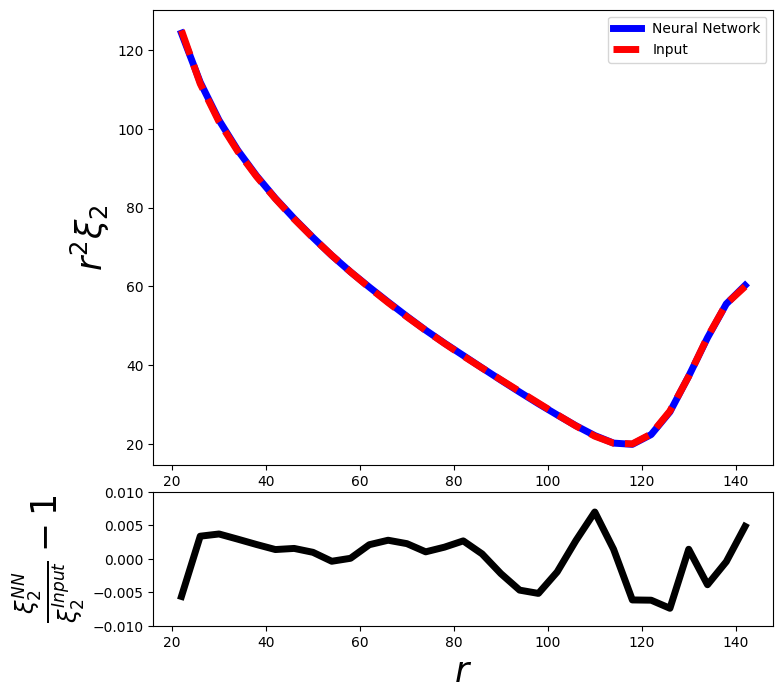

<Figure size 640x480 with 0 Axes>

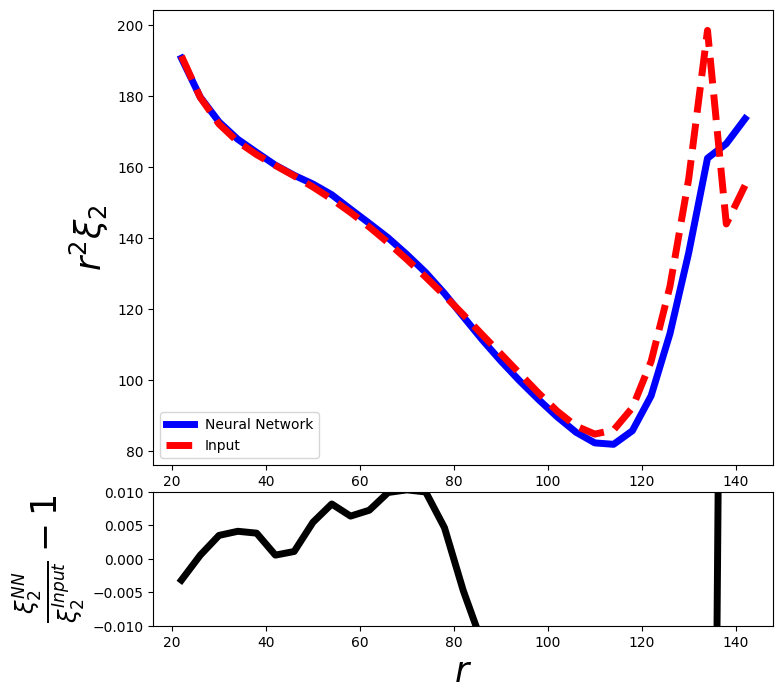

<Figure size 640x480 with 0 Axes>

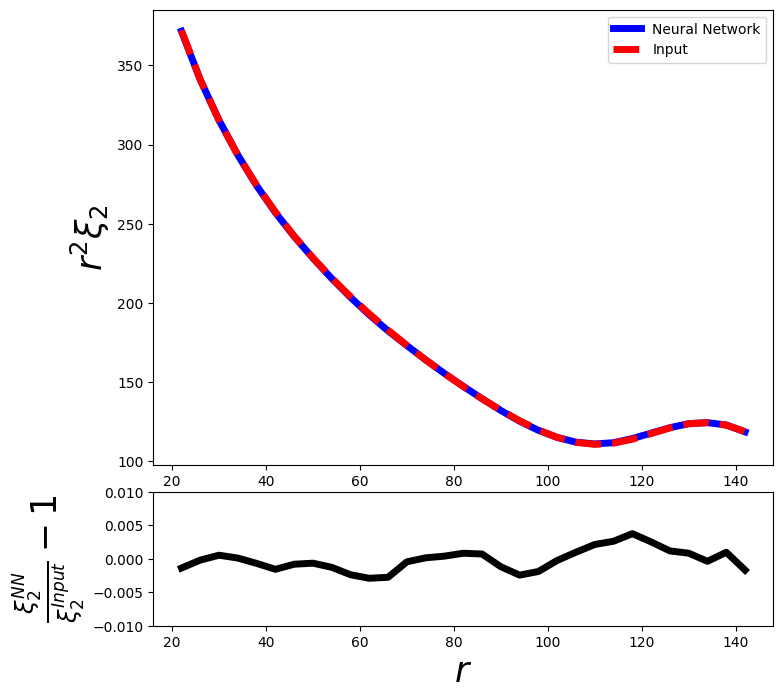

<Figure size 640x480 with 0 Axes>

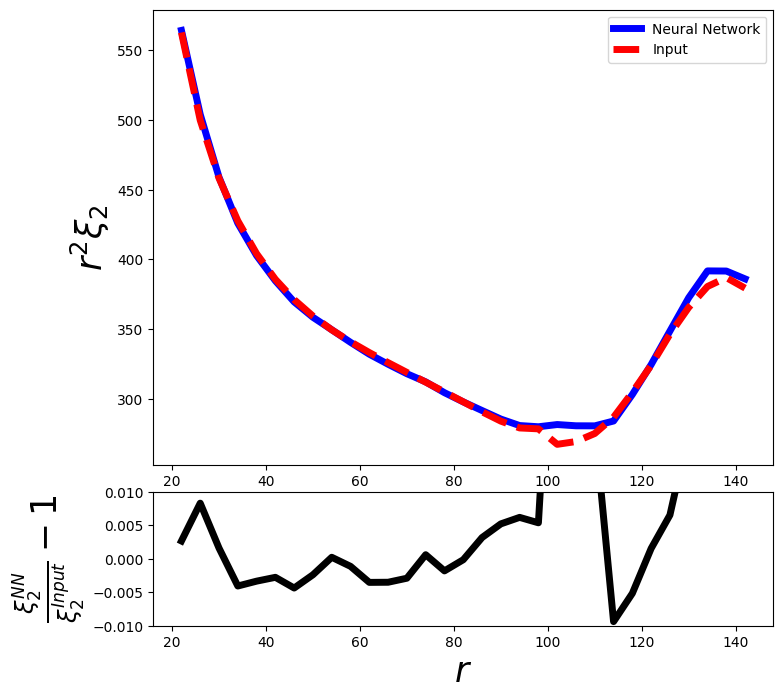

<Figure size 640x480 with 0 Axes>

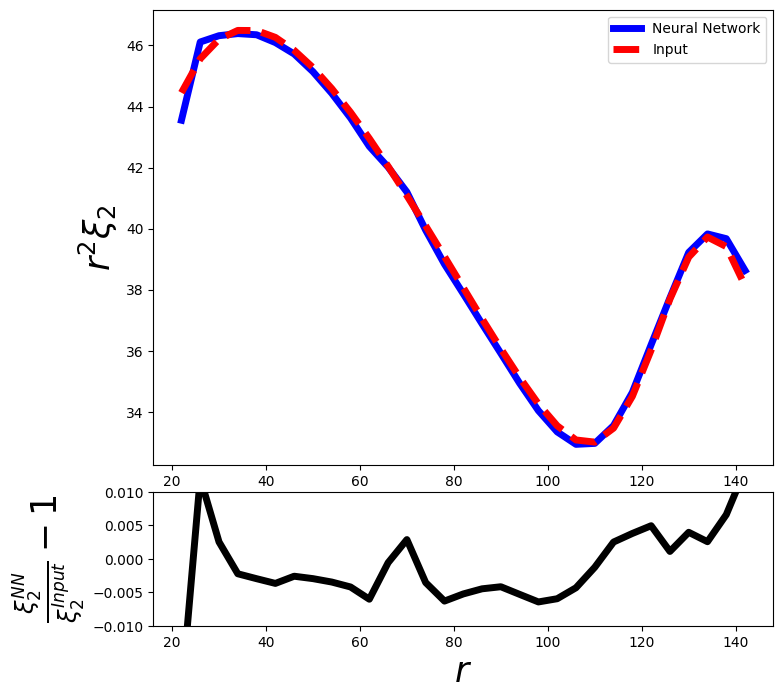

<Figure size 640x480 with 0 Axes>

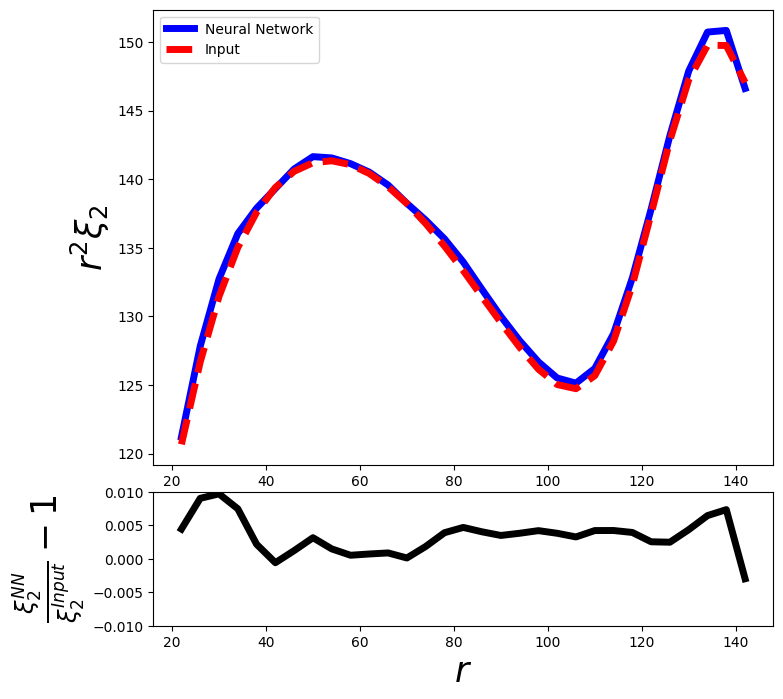

<Figure size 640x480 with 0 Axes>

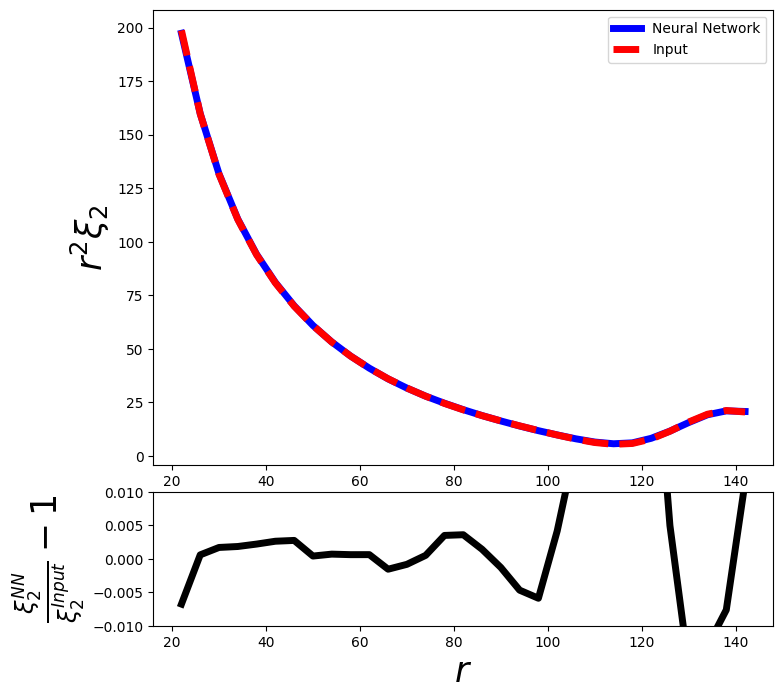

<Figure size 640x480 with 0 Axes>

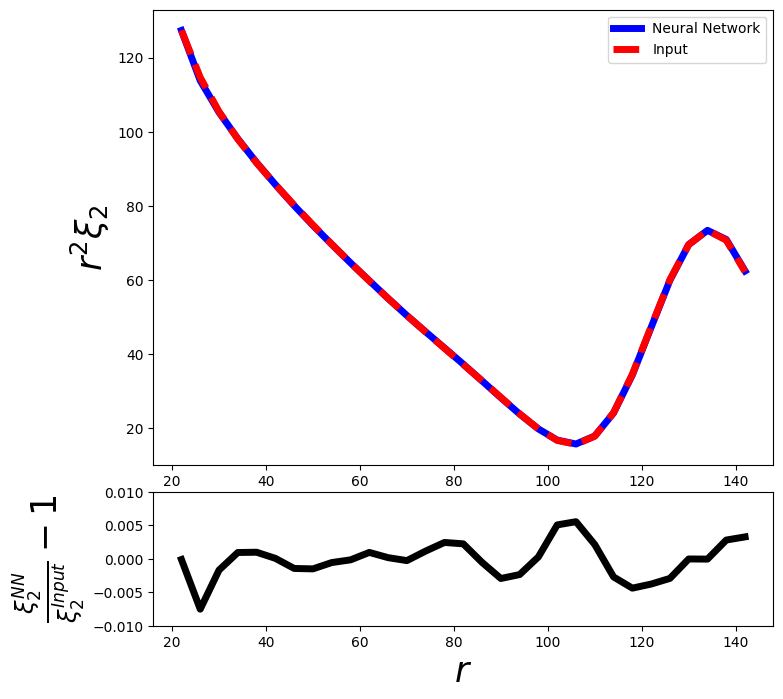

<Figure size 640x480 with 0 Axes>

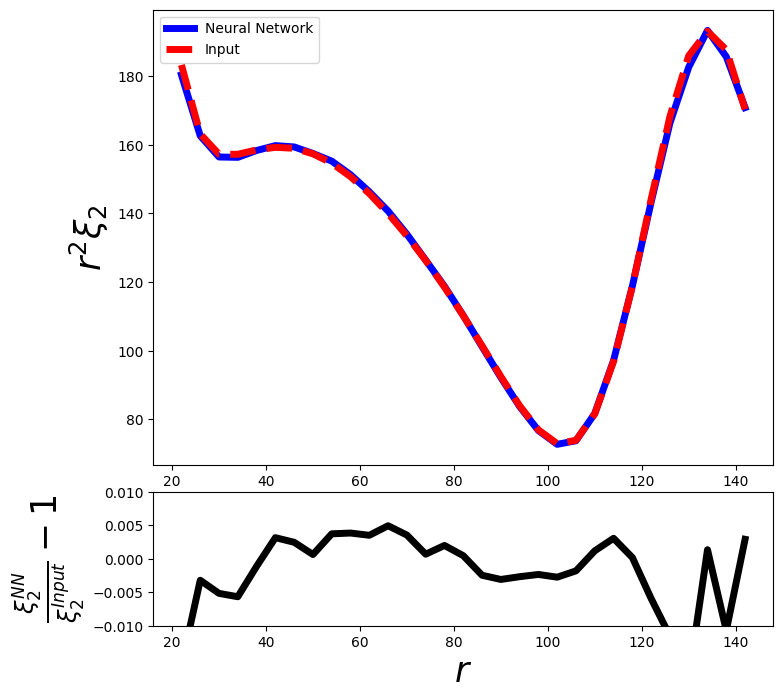

<Figure size 640x480 with 0 Axes>

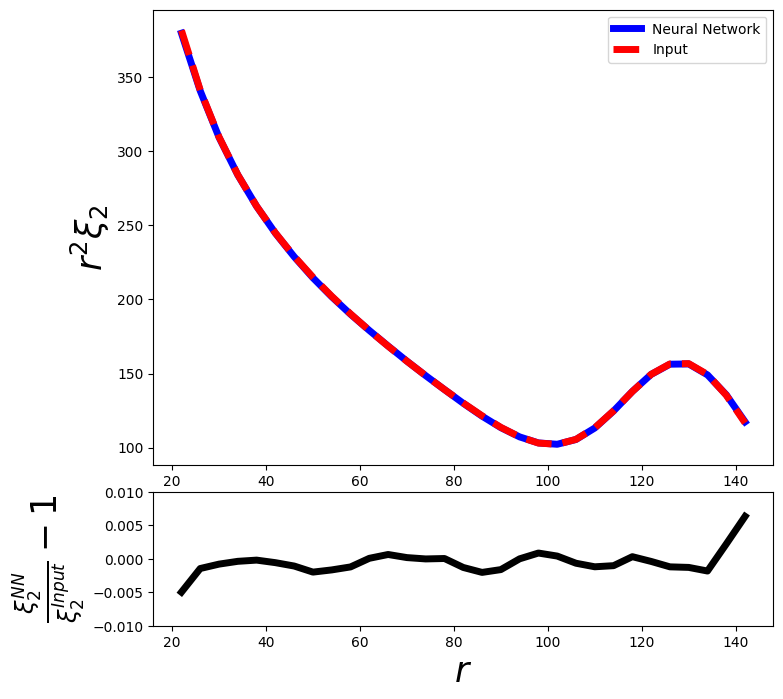

<Figure size 640x480 with 0 Axes>

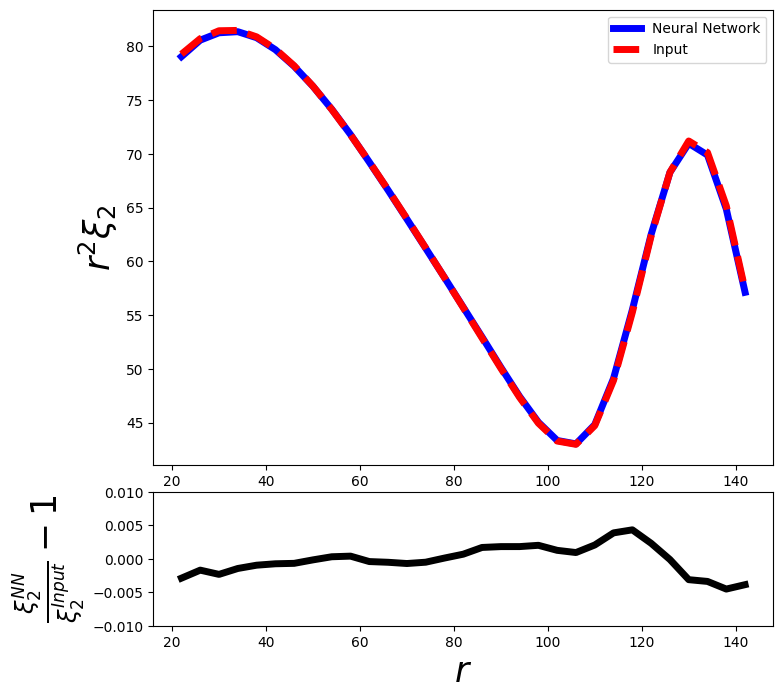

<Figure size 640x480 with 0 Axes>

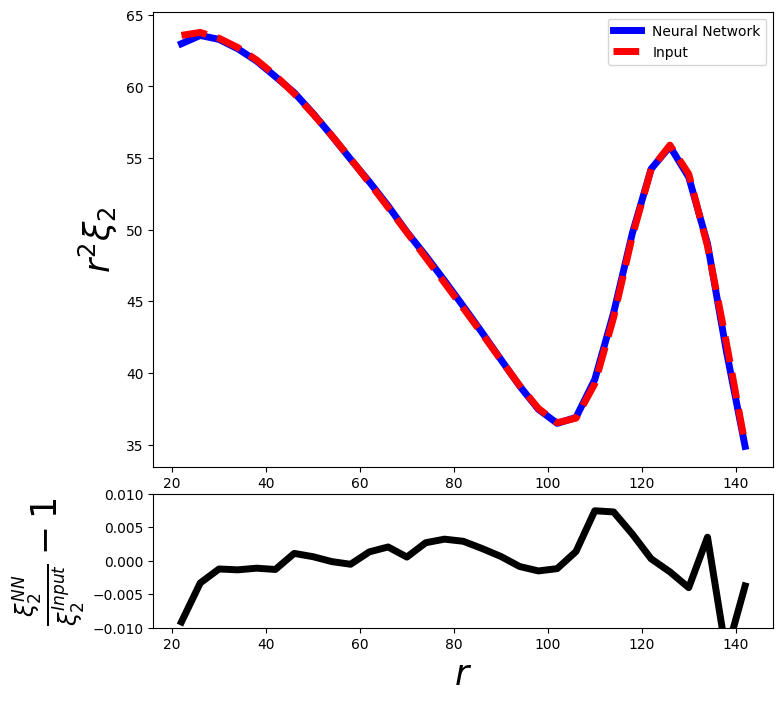

<Figure size 640x480 with 0 Axes>

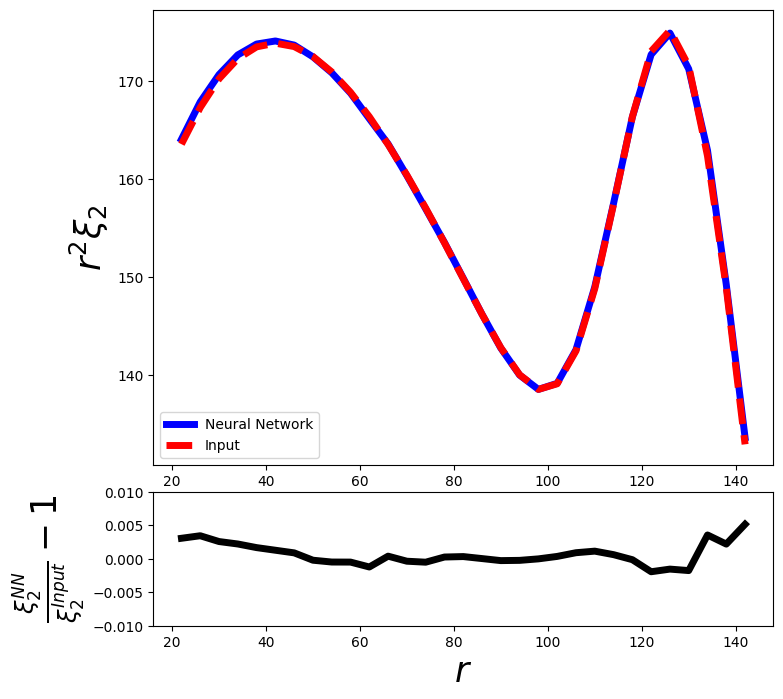

<Figure size 640x480 with 0 Axes>

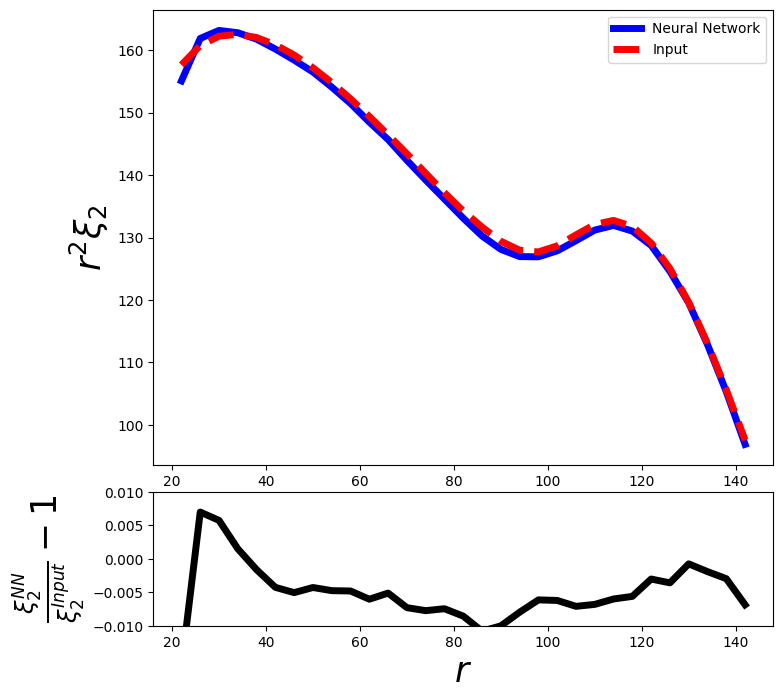

<Figure size 640x480 with 0 Axes>

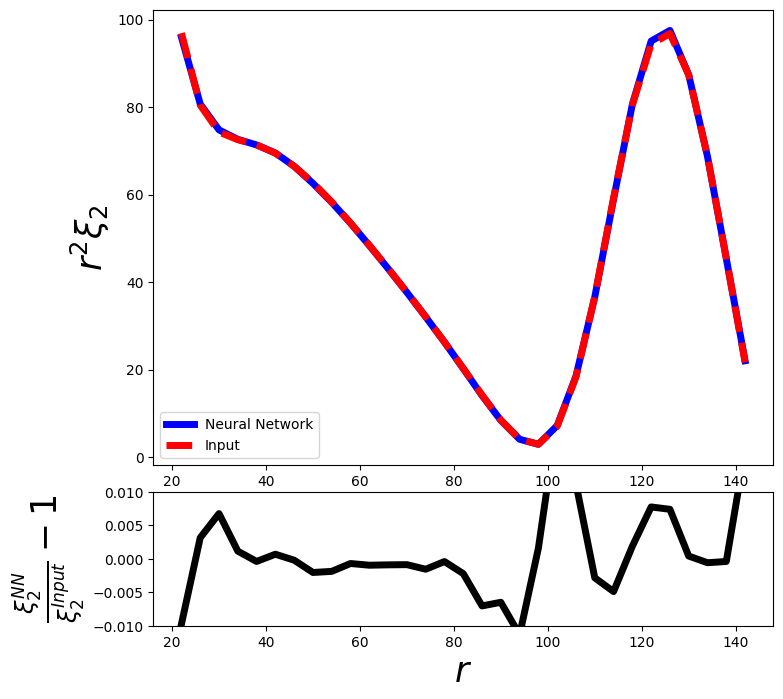

<Figure size 640x480 with 0 Axes>

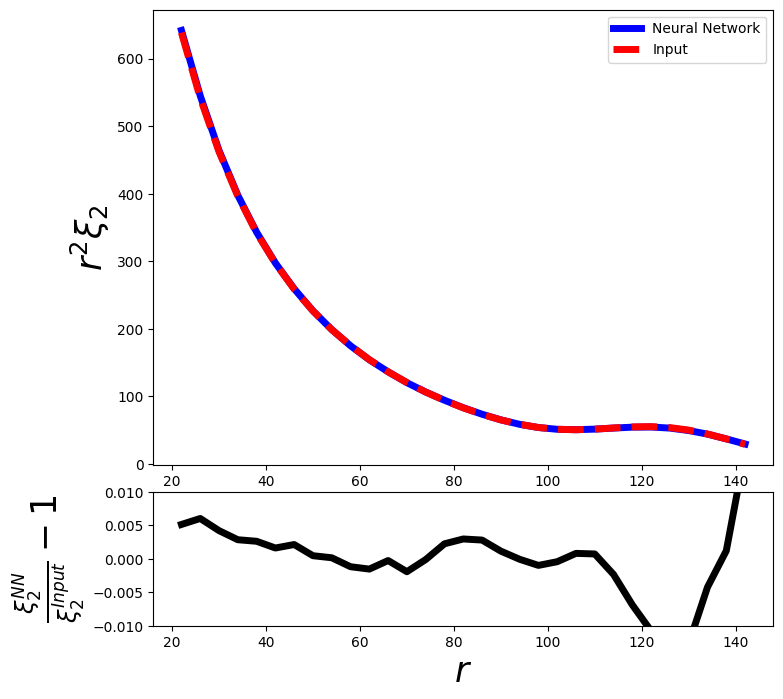

<Figure size 640x480 with 0 Axes>

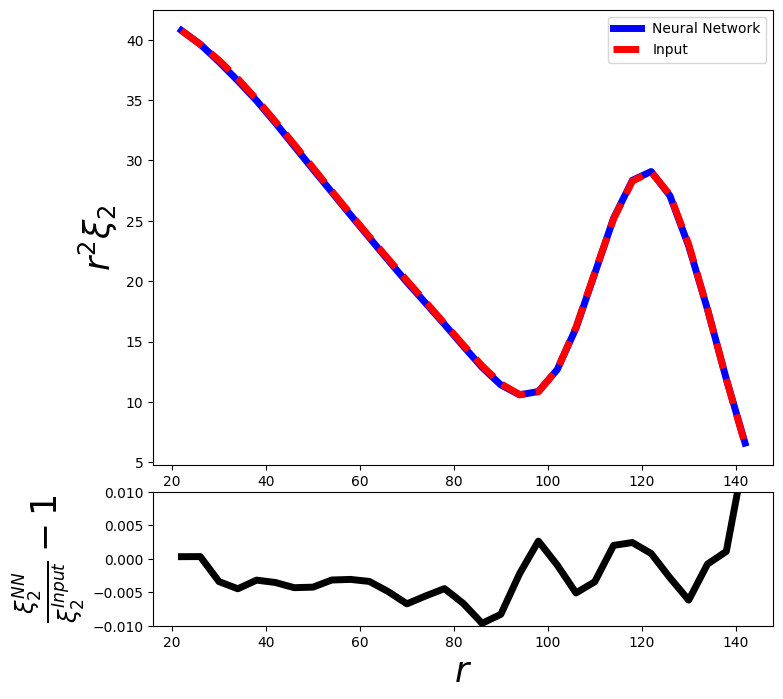

<Figure size 640x480 with 0 Axes>

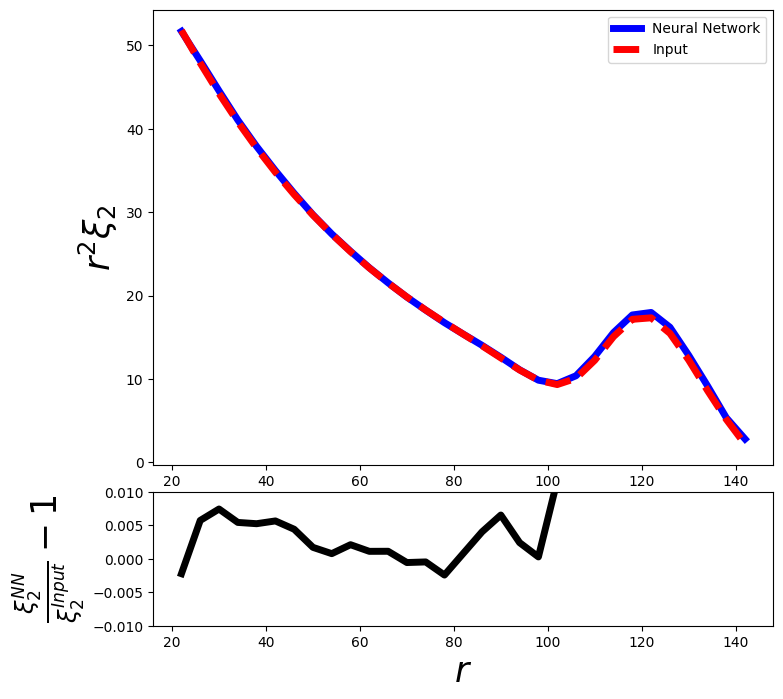

<Figure size 640x480 with 0 Axes>

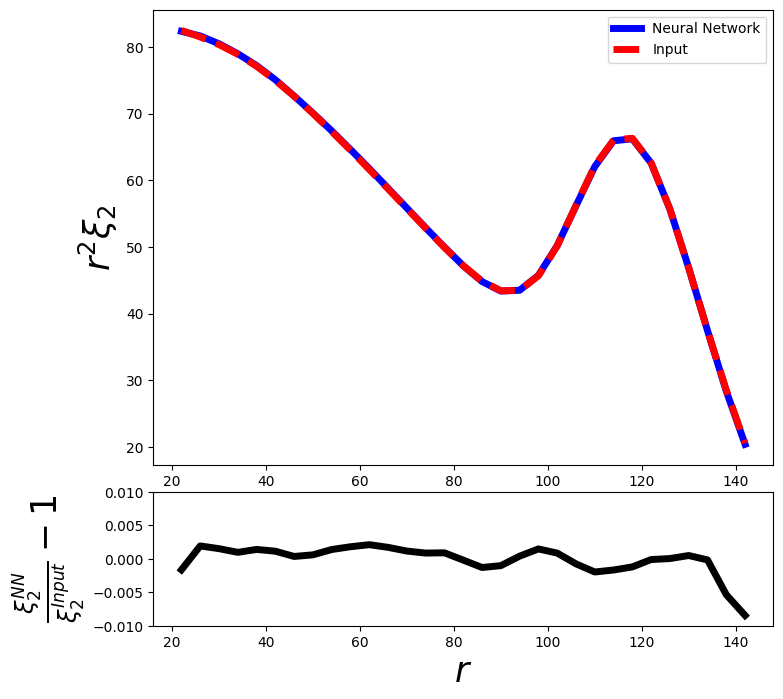

<Figure size 640x480 with 0 Axes>

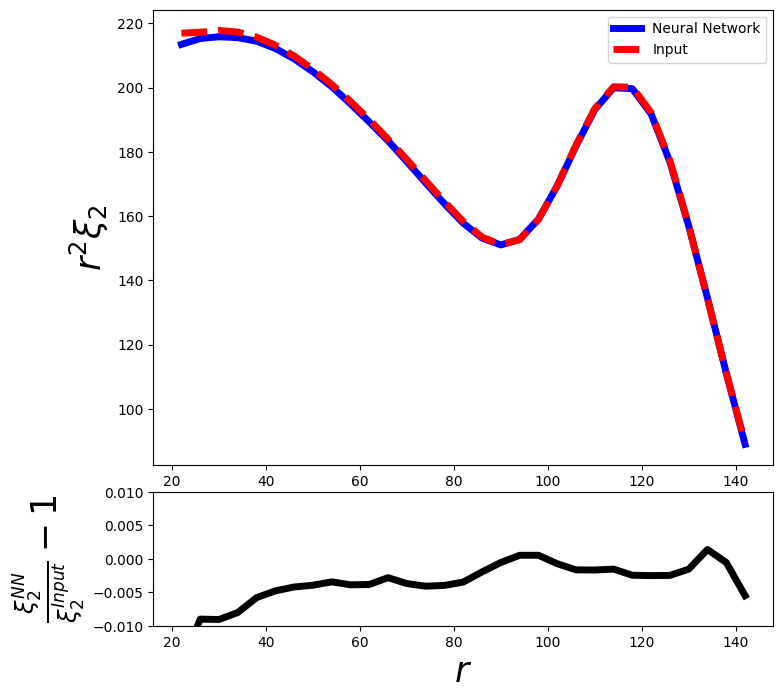

<Figure size 640x480 with 0 Axes>

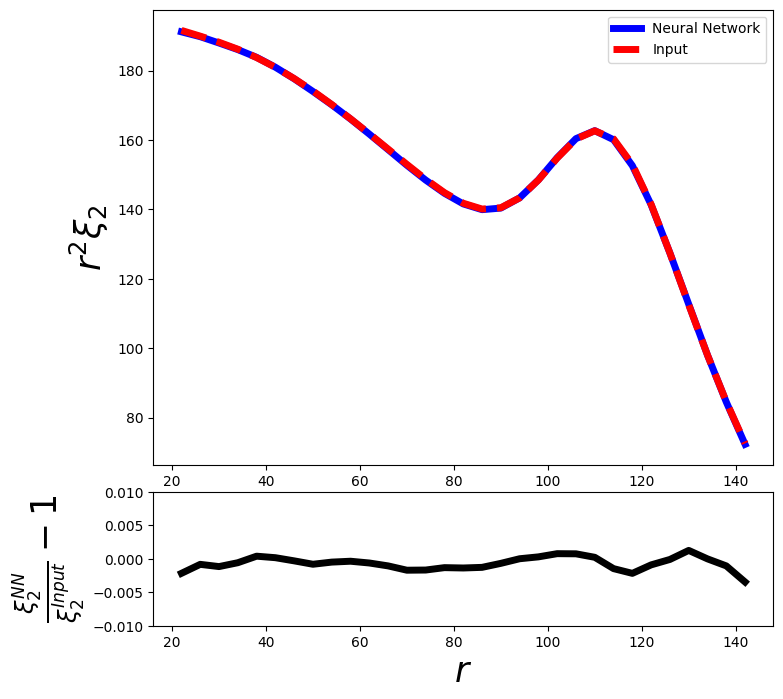

<Figure size 640x480 with 0 Axes>

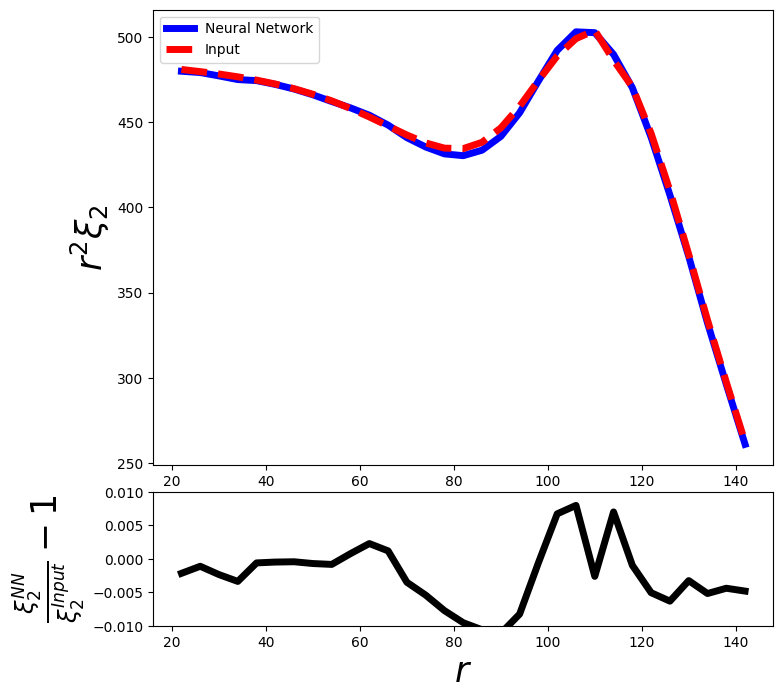

<Figure size 640x480 with 0 Axes>

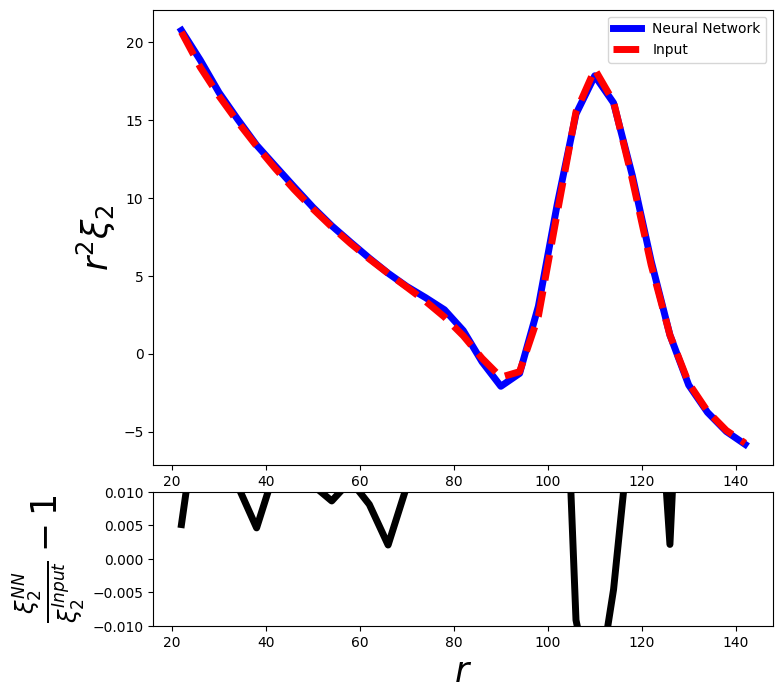

<Figure size 640x480 with 0 Axes>

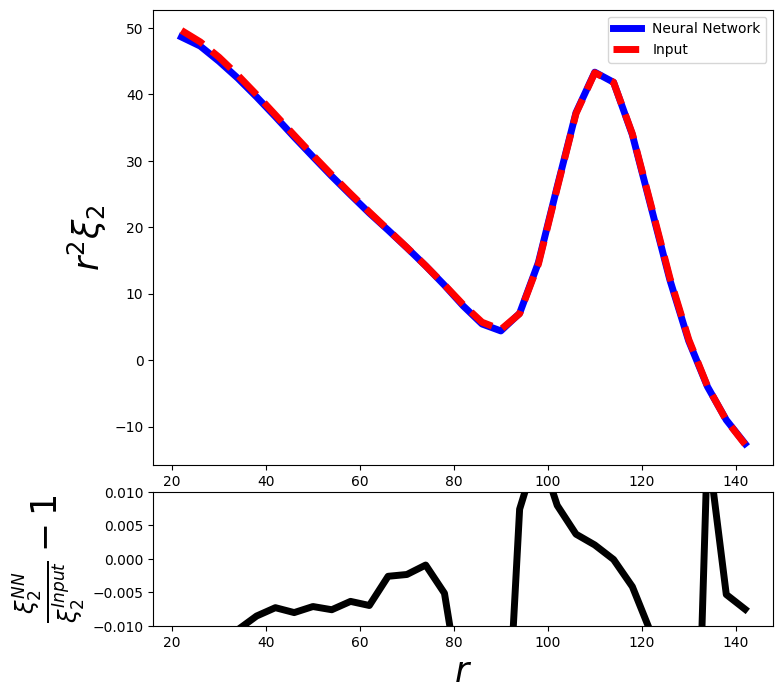

<Figure size 640x480 with 0 Axes>

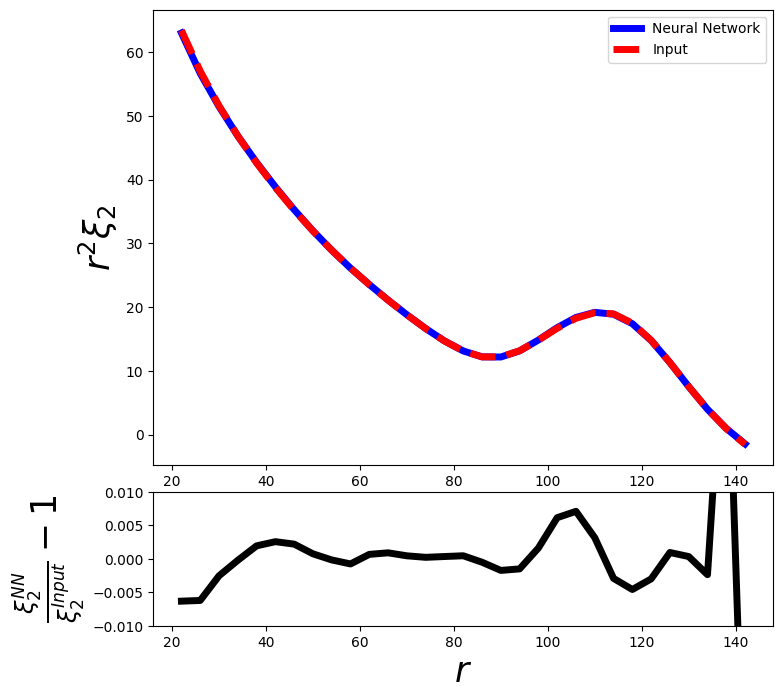

<Figure size 640x480 with 0 Axes>

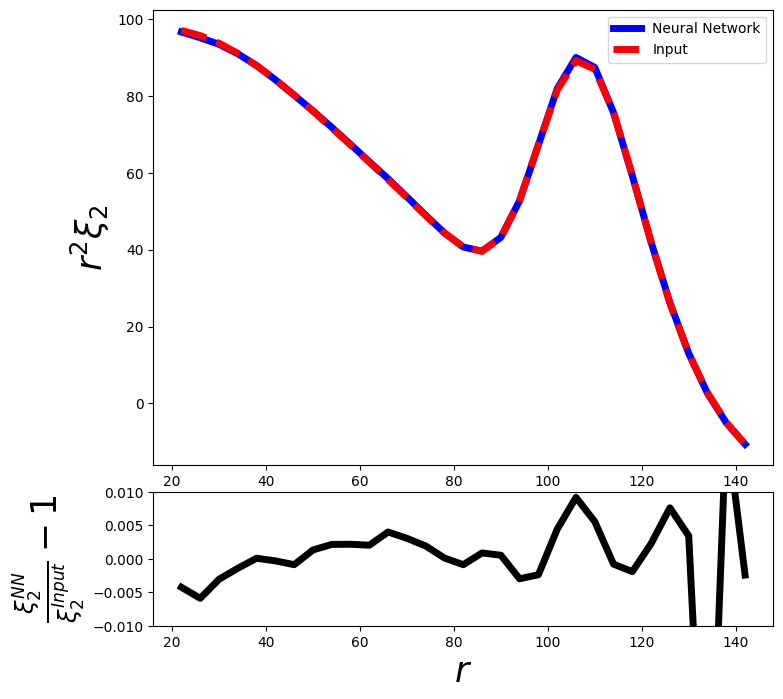

<Figure size 640x480 with 0 Axes>

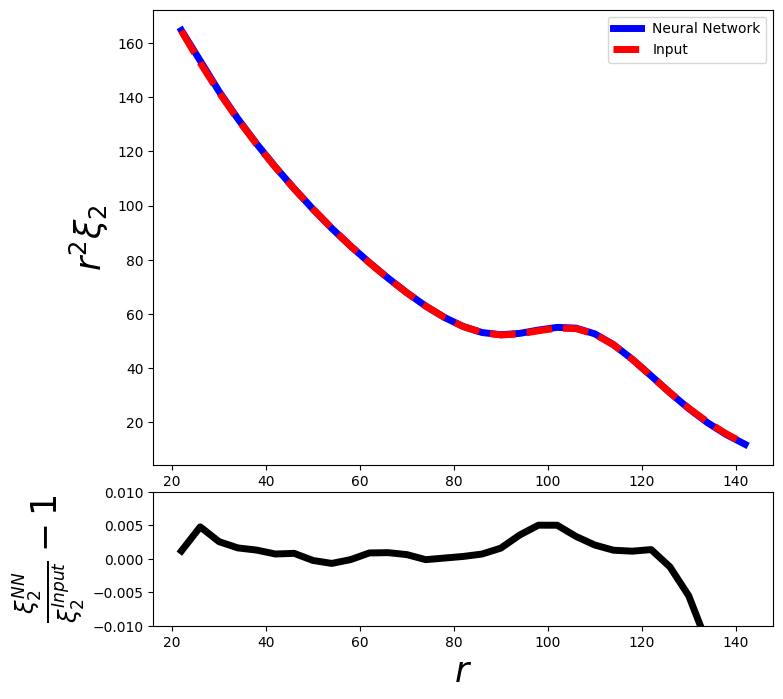

<Figure size 640x480 with 0 Axes>

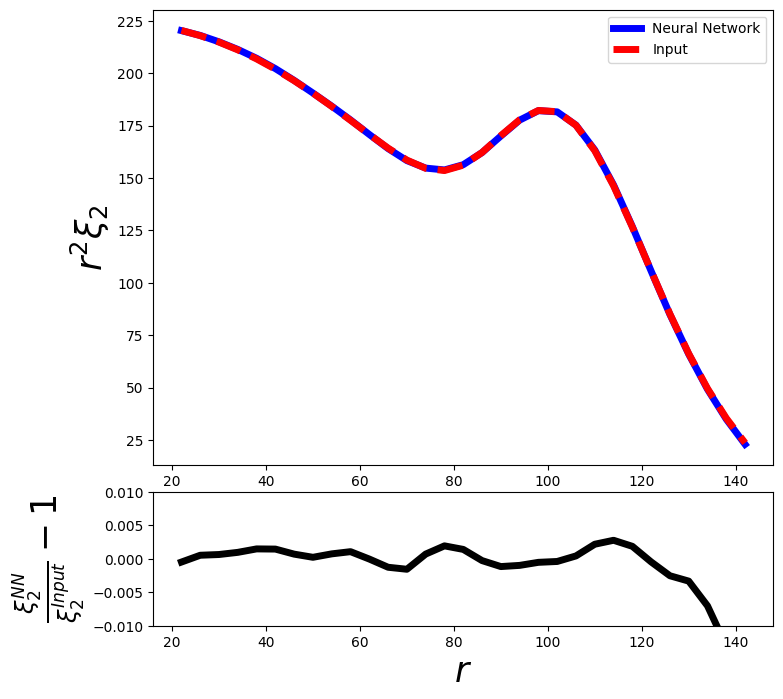

<Figure size 640x480 with 0 Axes>

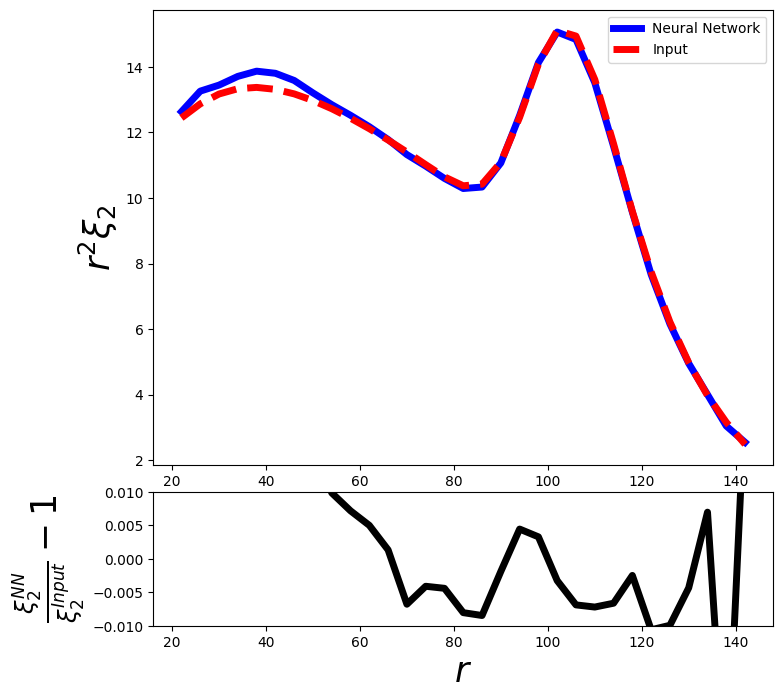

<Figure size 640x480 with 0 Axes>

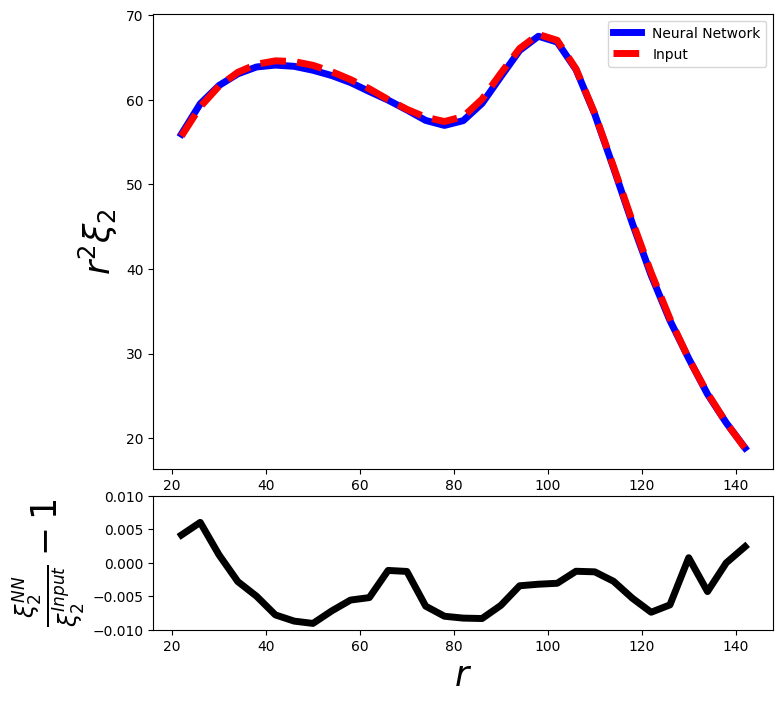

<Figure size 640x480 with 0 Axes>

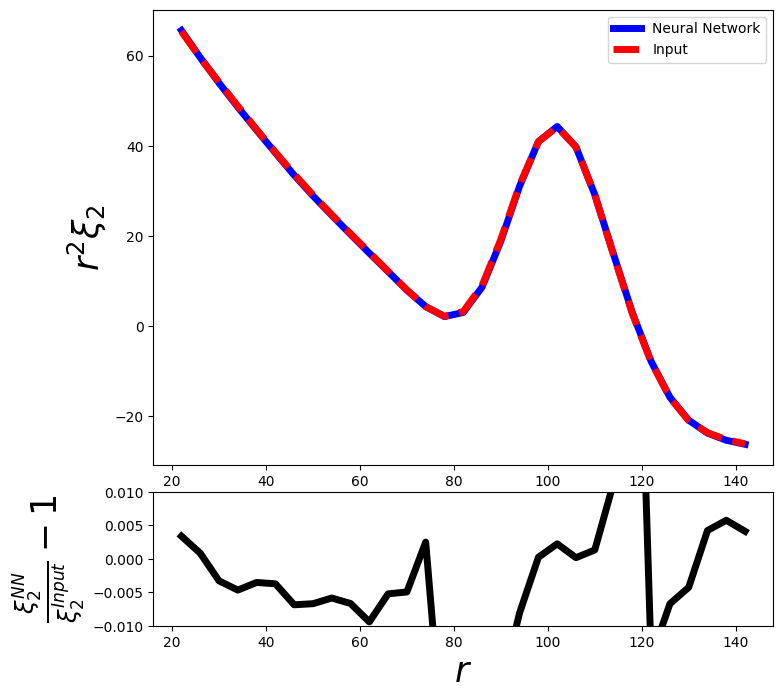

<Figure size 640x480 with 0 Axes>

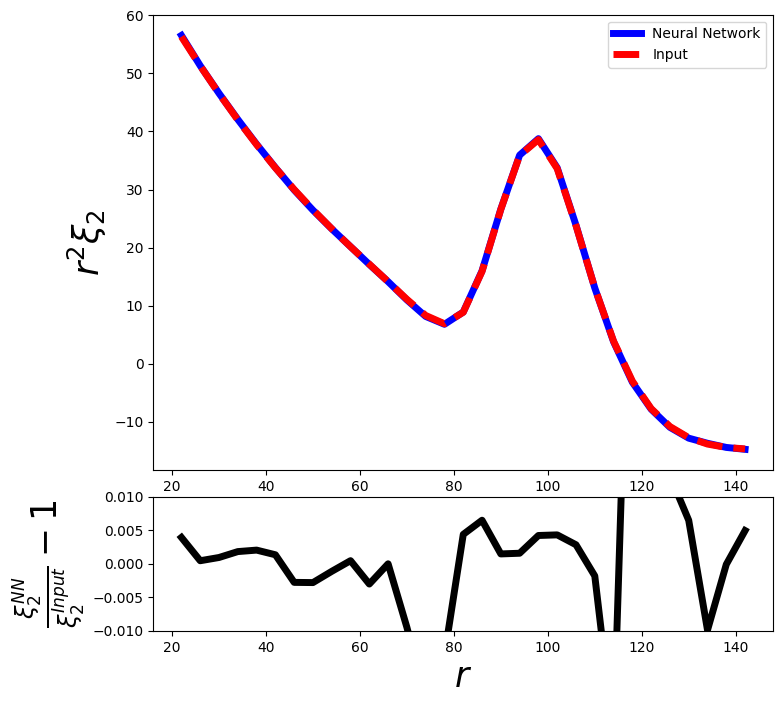

<Figure size 640x480 with 0 Axes>

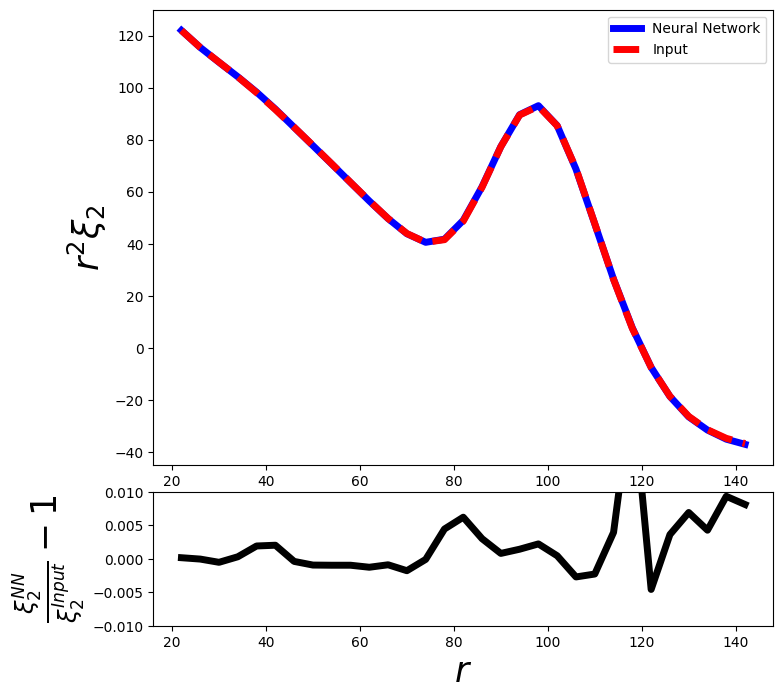

<Figure size 640x480 with 0 Axes>

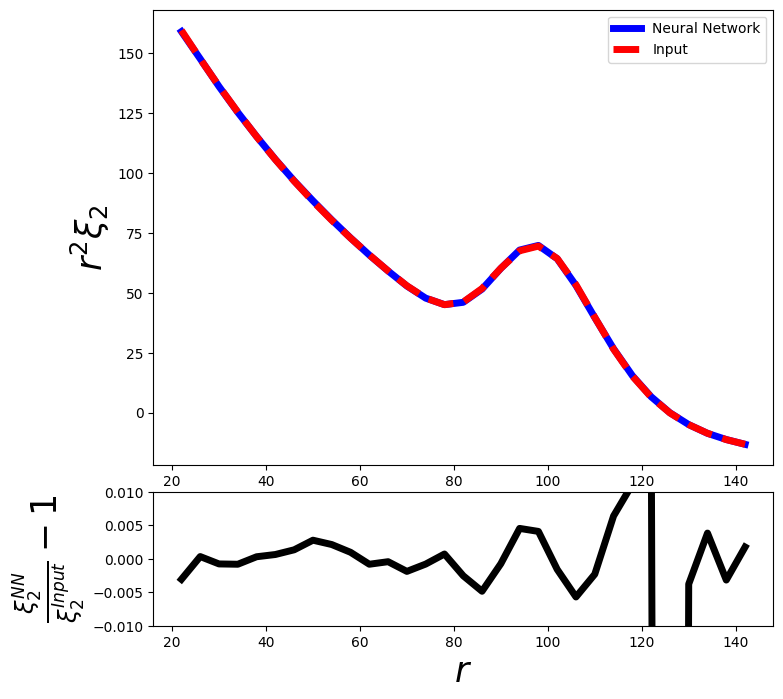

<Figure size 640x480 with 0 Axes>

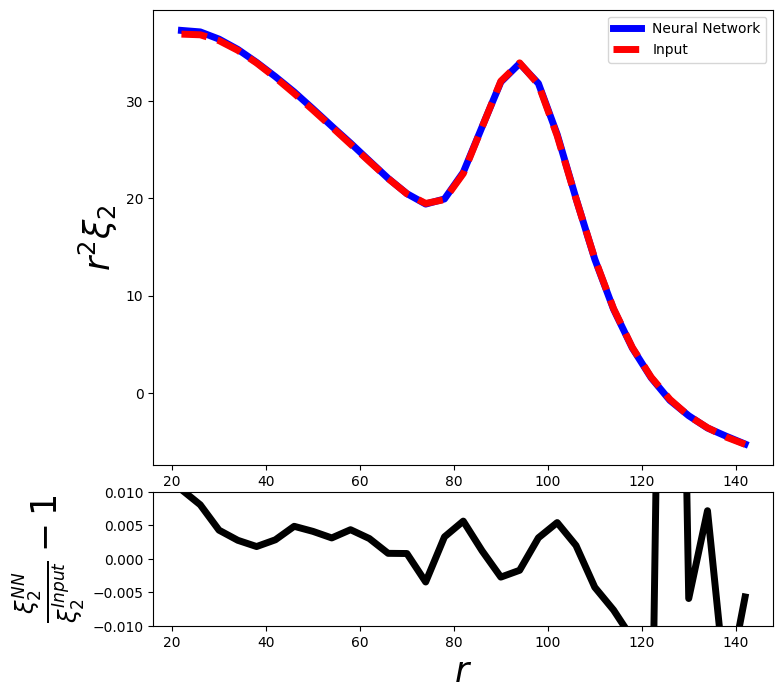

<Figure size 640x480 with 0 Axes>

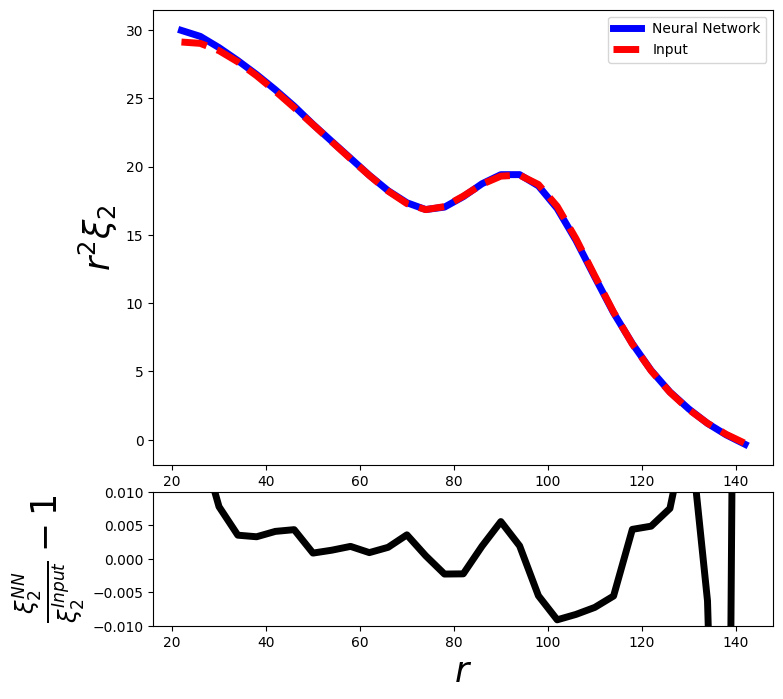

<Figure size 640x480 with 0 Axes>

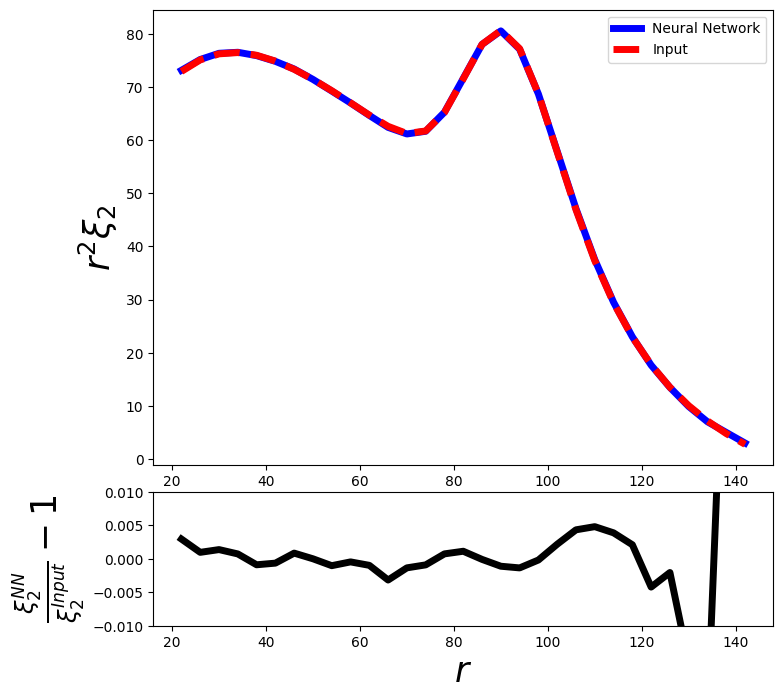

<Figure size 640x480 with 0 Axes>

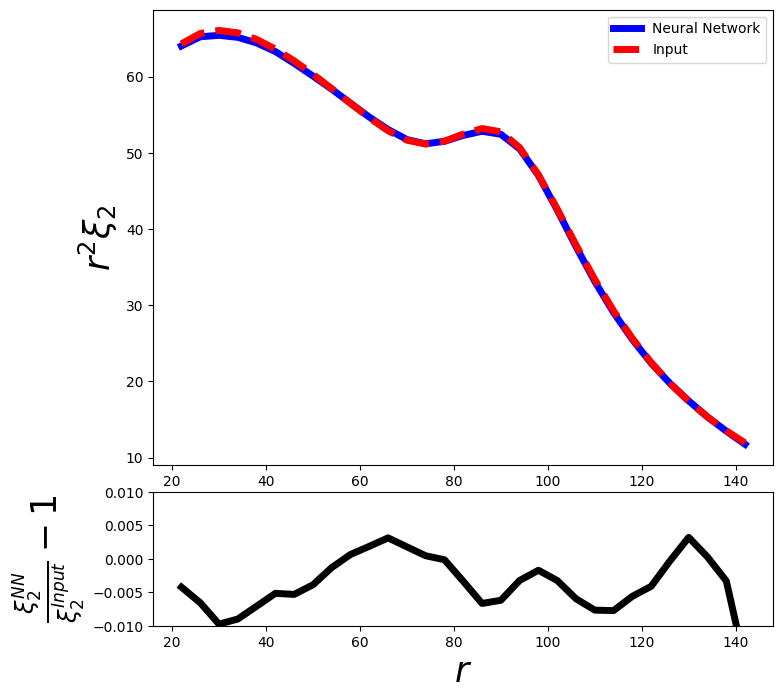

<Figure size 640x480 with 0 Axes>

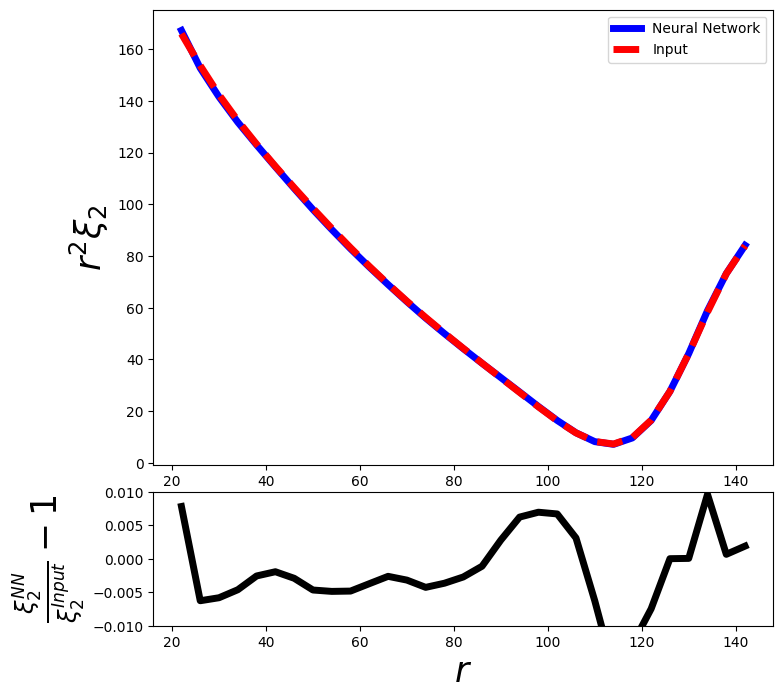

<Figure size 640x480 with 0 Axes>

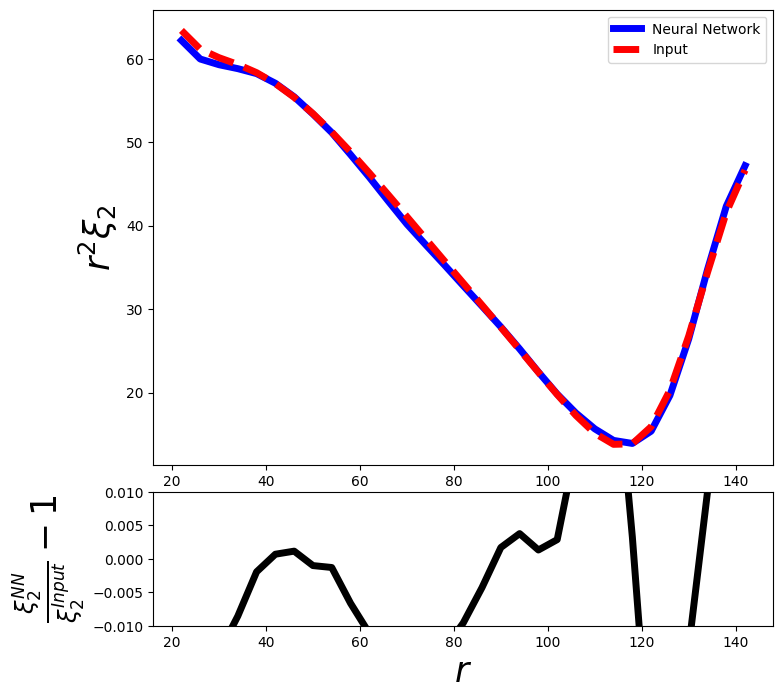

<Figure size 640x480 with 0 Axes>

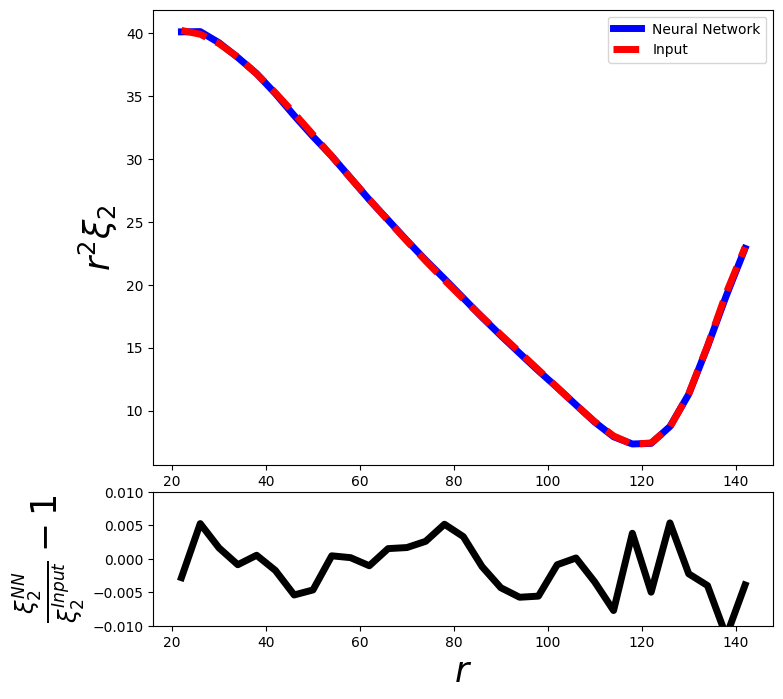

<Figure size 640x480 with 0 Axes>

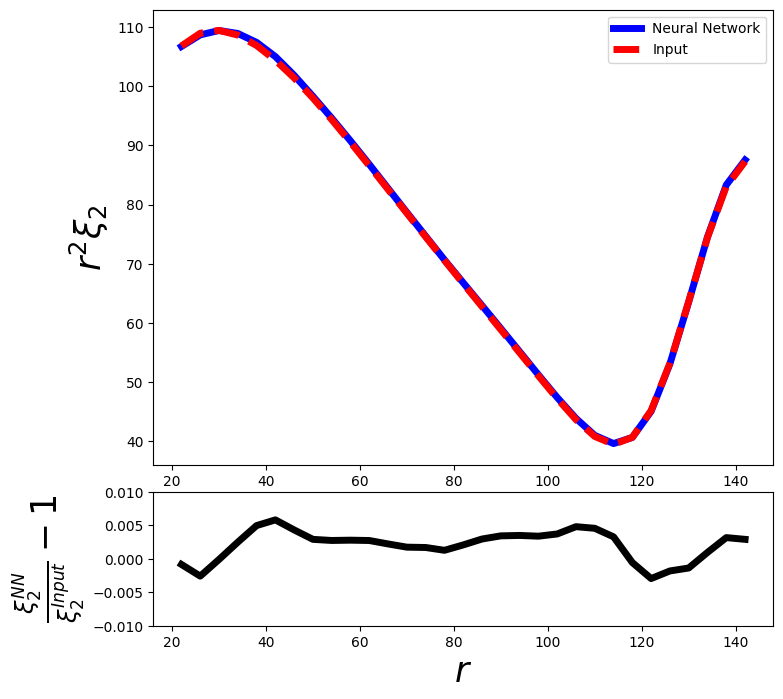

<Figure size 640x480 with 0 Axes>

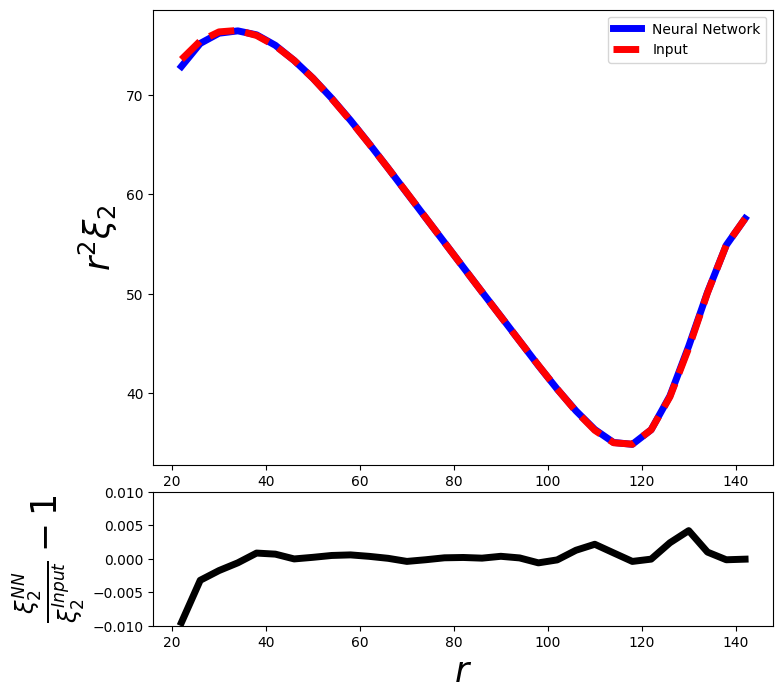

<Figure size 640x480 with 0 Axes>

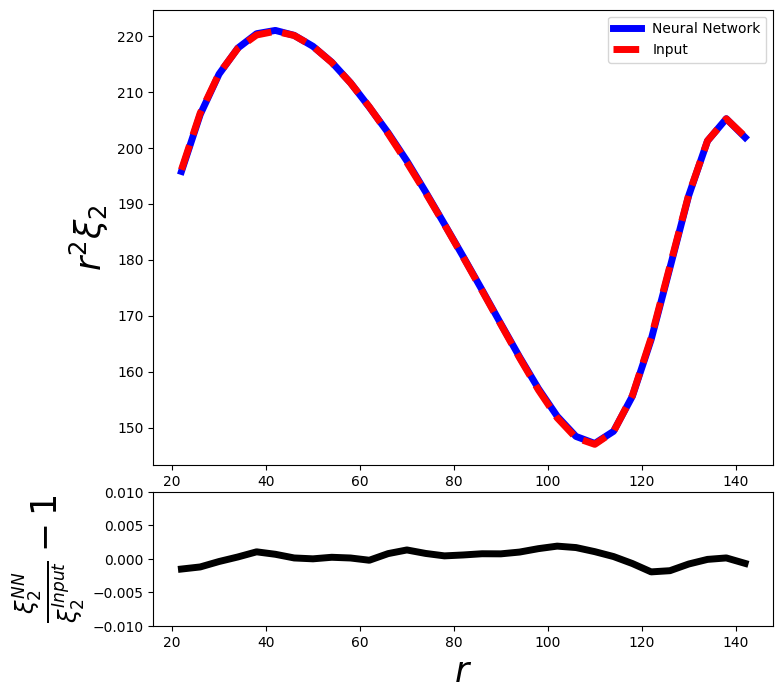

<Figure size 640x480 with 0 Axes>

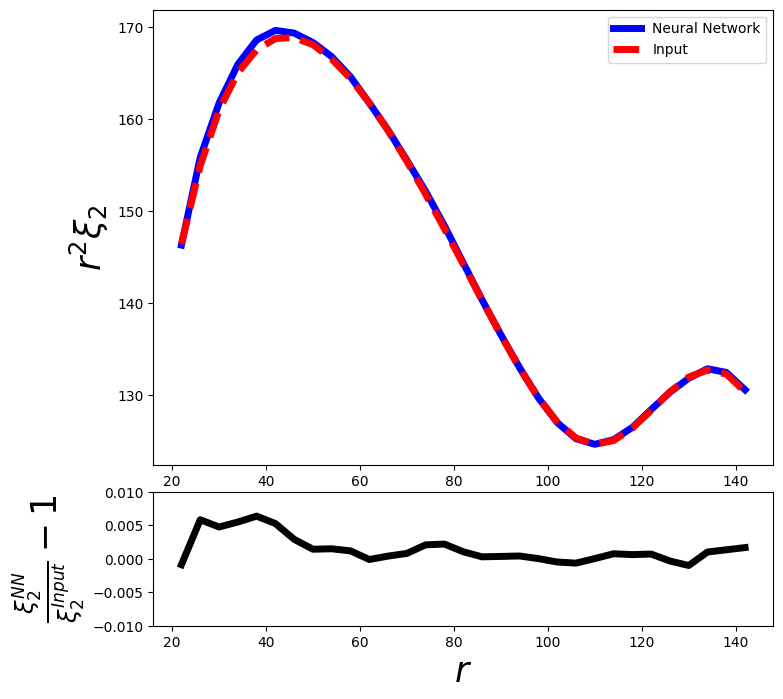

<Figure size 640x480 with 0 Axes>

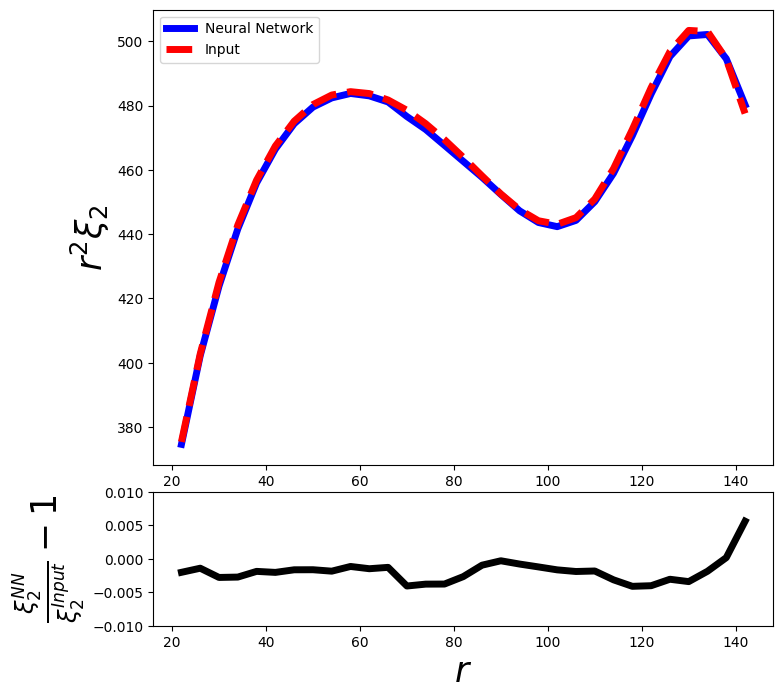

<Figure size 640x480 with 0 Axes>

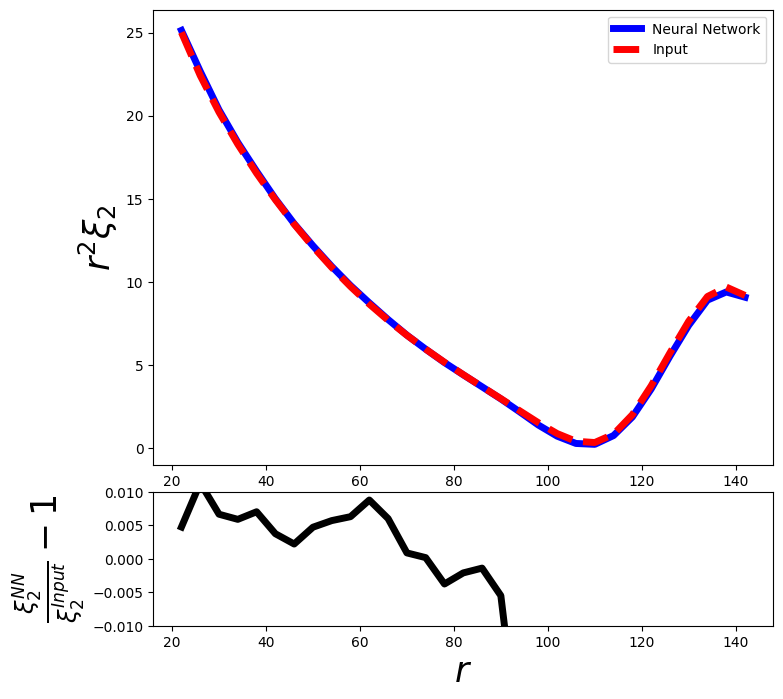

<Figure size 640x480 with 0 Axes>

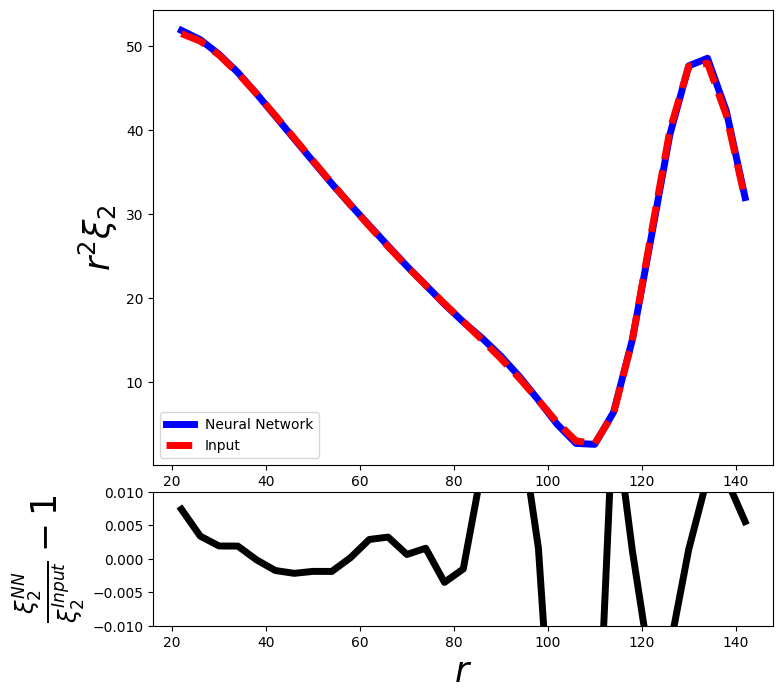

In [ ]:
for ii in range(50):

    
   plt.clf() 
   graf=plt.figure(figsize=(8,8))
   gs=plt.GridSpec(4,4)
   g1=graf.add_subplot(gs[:3,:])
   g2=graf.add_subplot(gs[3,:])
   g2.set_ylim([-0.01,0.01])
   g2.set_xlabel(r'$r$',fontsize=25)
   g1.set_ylabel(r'$r^2\xi_2$',fontsize=25) 
   g2.set_ylabel(r'$\frac{\xi^{NN}_2}{\xi^{Input}_2}-1$',fontsize=25) 
   g1.plot(rbin,rbin**2*multipole_modelled_nonorm[ii],color='blue',label='Neural Network',linewidth=5)
   g1.plot(rbin,rbin**2*multipole_test[ii],'--',color='red',label='Input',linewidth=5)
   g2.plot(rbin,(multipole_modelled_nonorm[ii]/multipole_test[ii])-1.0,color='black',linewidth=5)
   g1.legend()
   plt.show()  
